<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/2_Simple_Quant_Analysis_of_Daily_BTC_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Quant Analysis of Daily Bitcoin Returns

We'll start simple. In this notebook we're going to do some simple quant analysis of Bitcoin returns. 

The aim here is to learn about the Bitcoin process and give you a set of simple patterns for quant analysis of asset returns. 

In a later notebook, we'll expand these analysis patterns to the multi-asset case.

We'll be looking at:


*  Calculating returns (and the difference between log and simple returns)
*  Plotting histograms and distribution plots
*  Plotting conditional distributions
*  Auto-correlation
*  Seasonality effects 



In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmphzk0h7/remotes8321c7af08/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Get Daily BTC Price Data

In [3]:
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
prices %>%
  head()


Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


ℹ Downloading coinmetrics.csv

✔ Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


Let's just pull out BTC data, as that's all we'll need for this piece of analysis.

In [4]:
prices <- prices %>%
  filter(ticker == 'BTC')

prices %>%
  summarise(mindate = min(date),
            maxdate = max(date),
            minprice = min(price_usd),
            maxprice = max(price_usd),
            count = n())

mindate,maxdate,minprice,maxprice,count
<date>,<date>,<dbl>,<dbl>,<int>
2010-07-18,2022-06-01,0.05054062,67541.76,4337


And plotting and looking at a price series is a good way to check that your data looks OK.


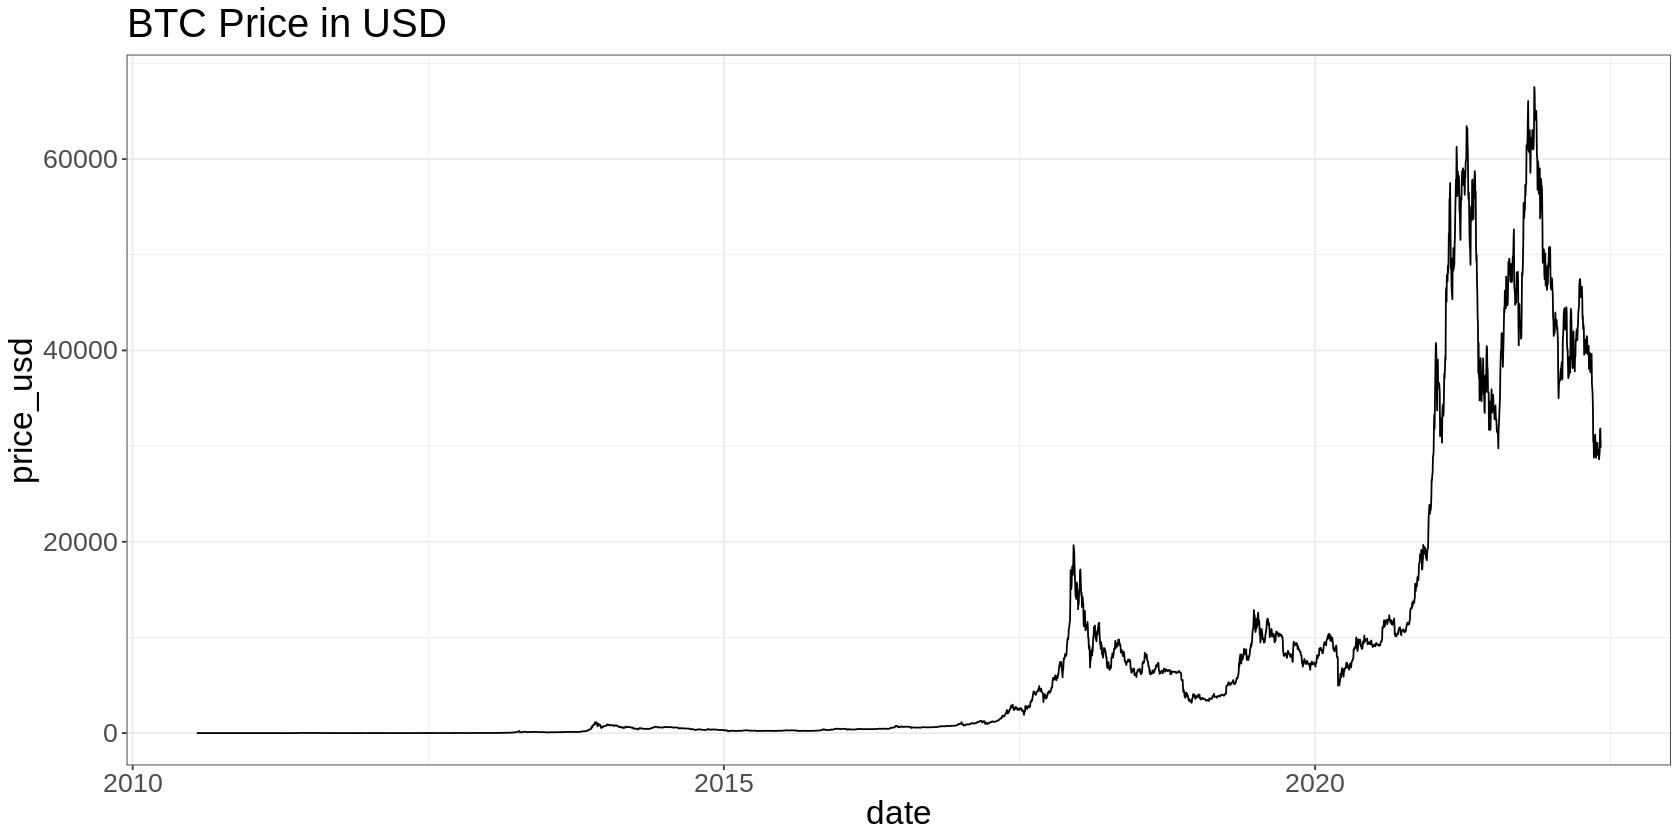

In [5]:
prices %>%
  ggplot(aes(x=date, y=price_usd)) +
    geom_line() +
    ggtitle('BTC Price in USD')

Looks as we'd expect. Let's zoom into the start of our data...

ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
BTC,2010-07-18,0.08584000,295959.2
BTC,2010-07-19,0.08080000,279285.2
BTC,2010-07-20,0.07473573,259000.4
BTC,2010-07-21,0.07919286,275266.5
BTC,2010-07-22,0.05846976,203749.6
BTC,2010-07-23,0.06059287,211735.7


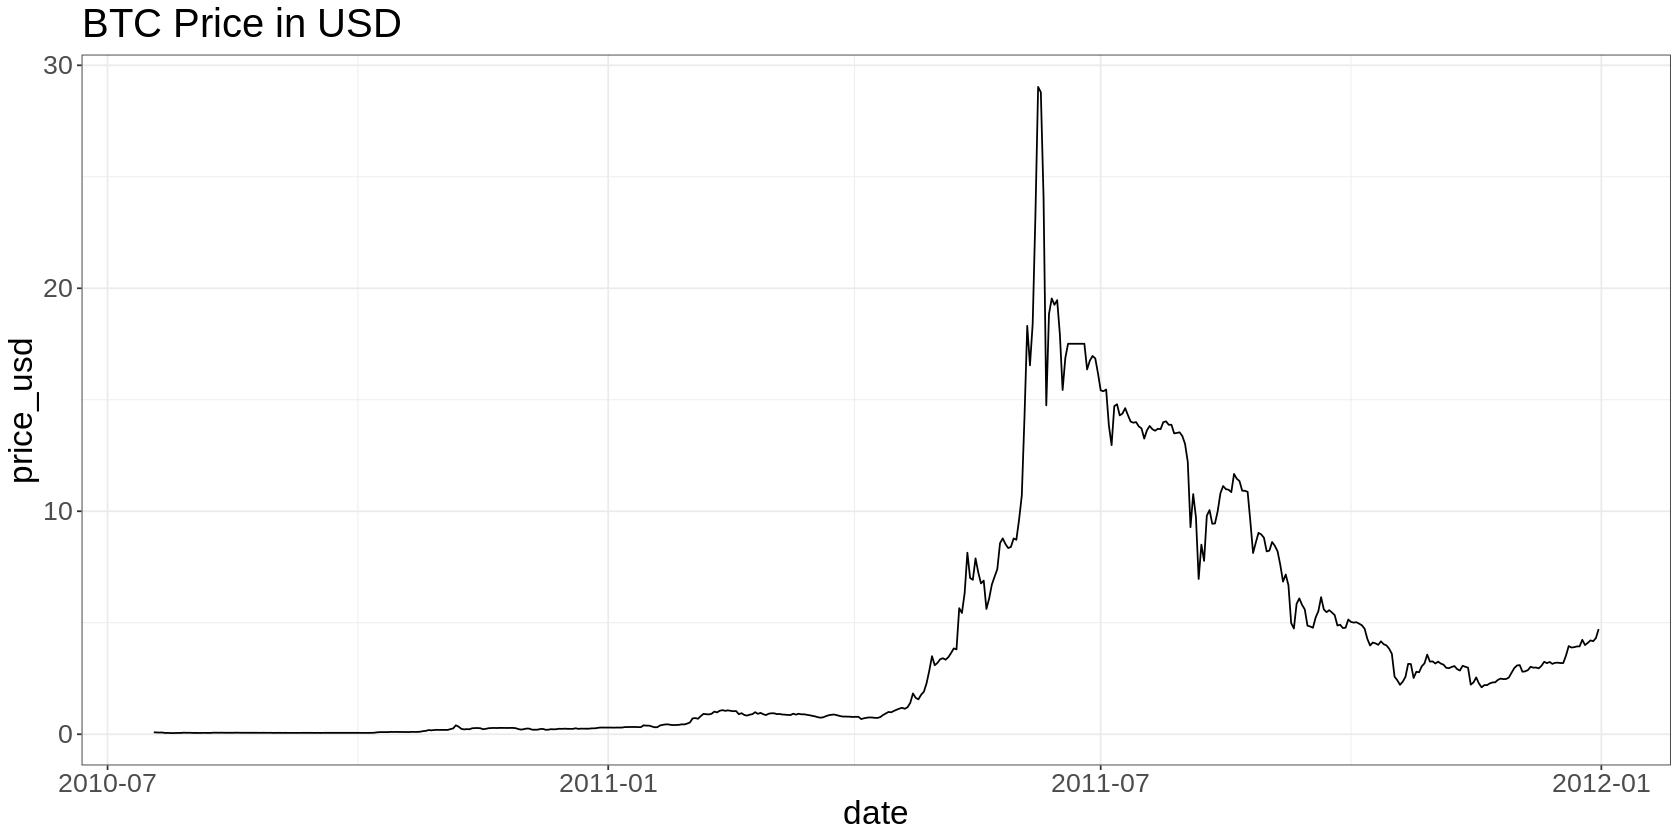

In [6]:
prices %>%
  filter(date <= '2011-12-31')  %>%
  ggplot(aes(x=date, y=price_usd)) +
    geom_line() +
    ggtitle('BTC Price in USD')

prices %>% 
  head()

# Calculating Returns


## Calculating Simple Returns

The simplified formula for simple returns $R_t$ is:
$$R_t = \frac{P_t}{P_{t-1}} - 1$$

Where $P_t$ Is price at the current timestamp

And $P_t-1$ Is the price for the previous timestamp


Before calculating your returns, you want to make sure:
1. Your data is in order
2. When dealing with a `tidy` data format you don't want to take $Pt-1$ from a different group 

In [7]:
simple_returns <- prices %>%
  arrange(date) %>% # Ensure data is arranged by rows
  mutate(simple_return = price_usd/lag(price_usd) - 1) 
  
head(simple_returns)

ticker,date,price_usd,market_cap,simple_return
<chr>,<date>,<dbl>,<dbl>,<dbl>
BTC,2010-07-18,0.08584000,295959.2,NA
BTC,2010-07-19,0.08080000,279285.2,-0.05871389
BTC,2010-07-20,0.07473573,259000.4,-0.07505286
BTC,2010-07-21,0.07919286,275266.5,0.05963859
BTC,2010-07-22,0.05846976,203749.6,-0.26167891
BTC,2010-07-23,0.06059287,211735.7,0.03631124


As we're going to analyze returns here, we don't need that NA record. 

We can remove it using `na.omit()`


In [8]:
simple_returns <- simple_returns %>%
  na.omit()
  
head(simple_returns)

ticker,date,price_usd,market_cap,simple_return
<chr>,<date>,<dbl>,<dbl>,<dbl>
BTC,2010-07-19,0.08080000,279285.2,-0.05871389
BTC,2010-07-20,0.07473573,259000.4,-0.07505286
BTC,2010-07-21,0.07919286,275266.5,0.05963859
BTC,2010-07-22,0.05846976,203749.6,-0.26167891
BTC,2010-07-23,0.06059287,211735.7,0.03631124
BTC,2010-07-24,0.05454000,191100.0,-0.09989409


## Chaining simple returns over time 

To chain multiple periods of simple returns we need to multiply them and then take away 1. 

A common mistake is to sum them up 

$$R = (1 + R_t) \cdot (1 + R_{t-1}) . . . \cdot (1 + R_{t - n}) - 1$$





In [9]:
simple_returns <- simple_returns %>%
  arrange(date) %>%
  mutate(chained_simple_returns = cumprod( 1 + simple_return) - 1) 
  
head(simple_returns)

ticker,date,price_usd,market_cap,simple_return,chained_simple_returns
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-07-19,0.08080000,279285.2,-0.05871389,-0.05871389
BTC,2010-07-20,0.07473573,259000.4,-0.07505286,-0.12936010
BTC,2010-07-21,0.07919286,275266.5,0.05963859,-0.07743636
BTC,2010-07-22,0.05846976,203749.6,-0.26167891,-0.31885181
BTC,2010-07-23,0.06059287,211735.7,0.03631124,-0.29411848
BTC,2010-07-24,0.05454000,191100.0,-0.09989409,-0.36463187


## Adding simple periodic returns for multiple assets

If you hold two assets $r_a$ and $r_b$ in weights $w_a$ and $w_b$ then the total periodic return is $w_a . r_a + w_b . r_b$

In [10]:
asset_returns <- c(0.1, 0.2)
asset_weights <- c(0.5, 0.5)

sum(asset_returns * asset_weights)

[1] 0.15

The process of aggregating multiple-asset returns over time involves some care, because the weights of the assets you hold (in $) will change as the assets increase or decrease in value. 

We will cover the multi-asset case in another notebook.

## Calculating Log Returns (Continuously compounded returns)

The simplified formula for log returns $r_t$ is:

$$r_t = ln(\frac{P_t}{P_{t-1}})$$

Same as with  simple returns $P_t$ is price at current timestamp, and $P_{t-1}$ is price at previous timestamp. 

Again you want your data in order, and you don't want to mix up your prices from a different ticker.

In [11]:
log_returns <- prices %>%
  arrange(date) %>%
  mutate(log_return = log(price_usd/lag(price_usd))) %>%
  na.omit()

tail(log_returns)


ticker,date,price_usd,market_cap,log_return
<chr>,<date>,<dbl>,<dbl>,<dbl>
BTC,2022-05-27,28612.04,545088669359,-0.024867987
BTC,2022-05-28,29045.52,553373761225,0.015036622
BTC,2022-05-29,29430.07,560727563225,0.013152630
BTC,2022-05-30,31735.95,604691877439,0.075433358
BTC,2022-05-31,31831.41,606539699591,0.003003259
BTC,2022-06-01,29825.92,568350982618,-0.065075635


But wait, what is a log return and why would I want one?

It's the *natural logarithm* of the *simple gross return* over a period $r_t = ln(1 + R_t) = ln(P_t/P_{t-1})$

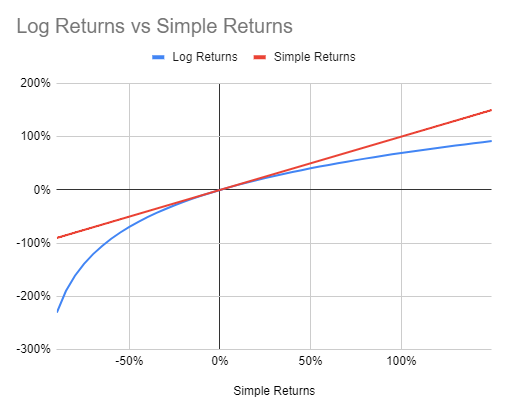


The chart shows the log reutrns in blue against simple returns in red.

We see that:

*   Log returns are always smaller than simple returns
* The values are very close when the magnitude of returns is small, but can differ a lot when it’s large.

But if we zoom into the chart between -5% and 5% we see that log returns very closely approximate simple returns at the magnitudes we tend to work with.

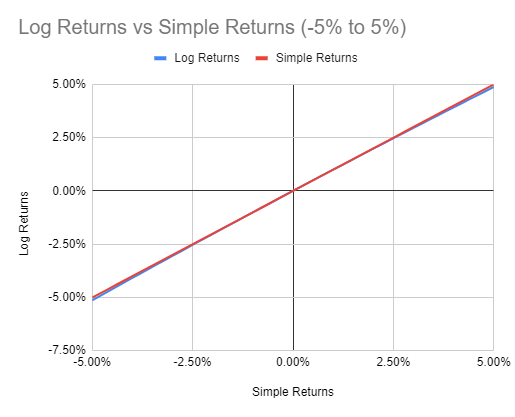


Log returns have some useful properties which can make our calculations easier. One of those is that the log return for a period of time is simply the sum of the periodic returns within that time period. 

We don’t have to multiply them – as we have to with simple returns. This can make certain calculations much easier. 

OK but what does a "log return" actually represent? Why is it called a continuously compounded return?

Consider an asset that goes from $P_0 = 100$ to $P_{365} = 200$ in 365 days.  

In [12]:
simplereturn <- 200/100 - 1
logreturn <- log(200/100)

simplereturn
logreturn

[1] 1

[1] 0.6931472

They're very different... We're going to show why. 

What was the daily simple return in this case? 

You might say it's $100 / 365 = 0.274%$ per day , but let's look at what happens if we chain those returns together.

Remember to aggregate simple returns over time we take the cumulative product of gross returns $R_t = (1 + R_t) \cdot (1 + R_{t-1}) . . . \cdot (1 + R_{t - n}) - 1$

In this case all our returns are the same so we'll do

$R = (1 + r/365)^{365}$


In [13]:
((1 + simplereturn/365)^365) - 1

[1] 1.714567

171% is much bigger than 100%. That's because we compounded our money every day. So each day we were calculating returns on a bigger and bigger amount of money. 

Let's plot it...

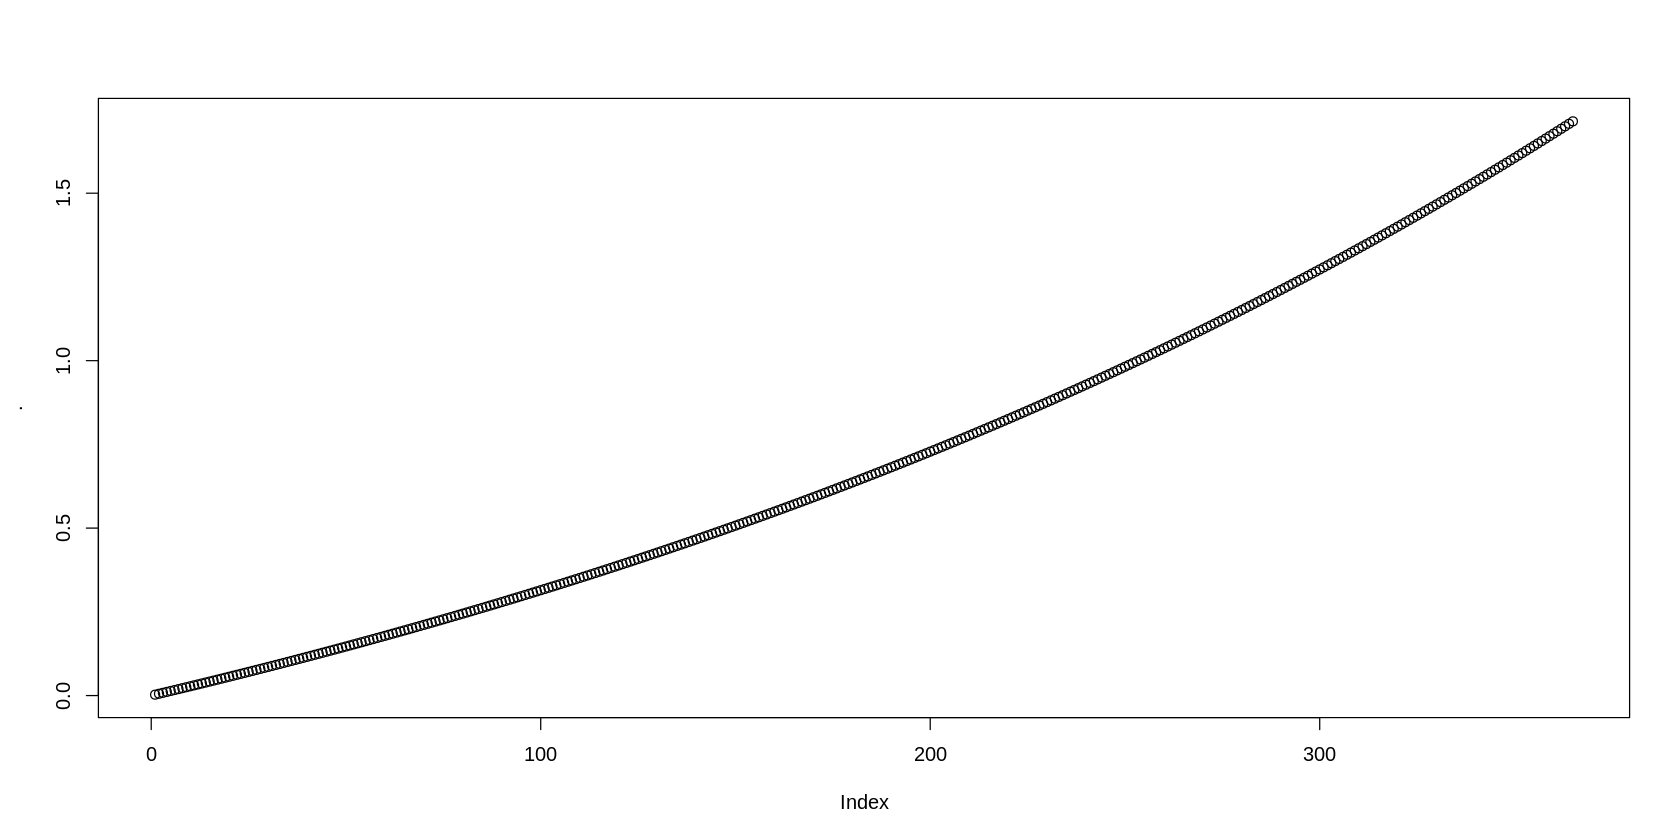

In [14]:
(cumprod(rep(1 + simplereturn/365, 365)) - 1) %>% plot()

What if instead we compounded with the log returns?

[1] 0.9986858

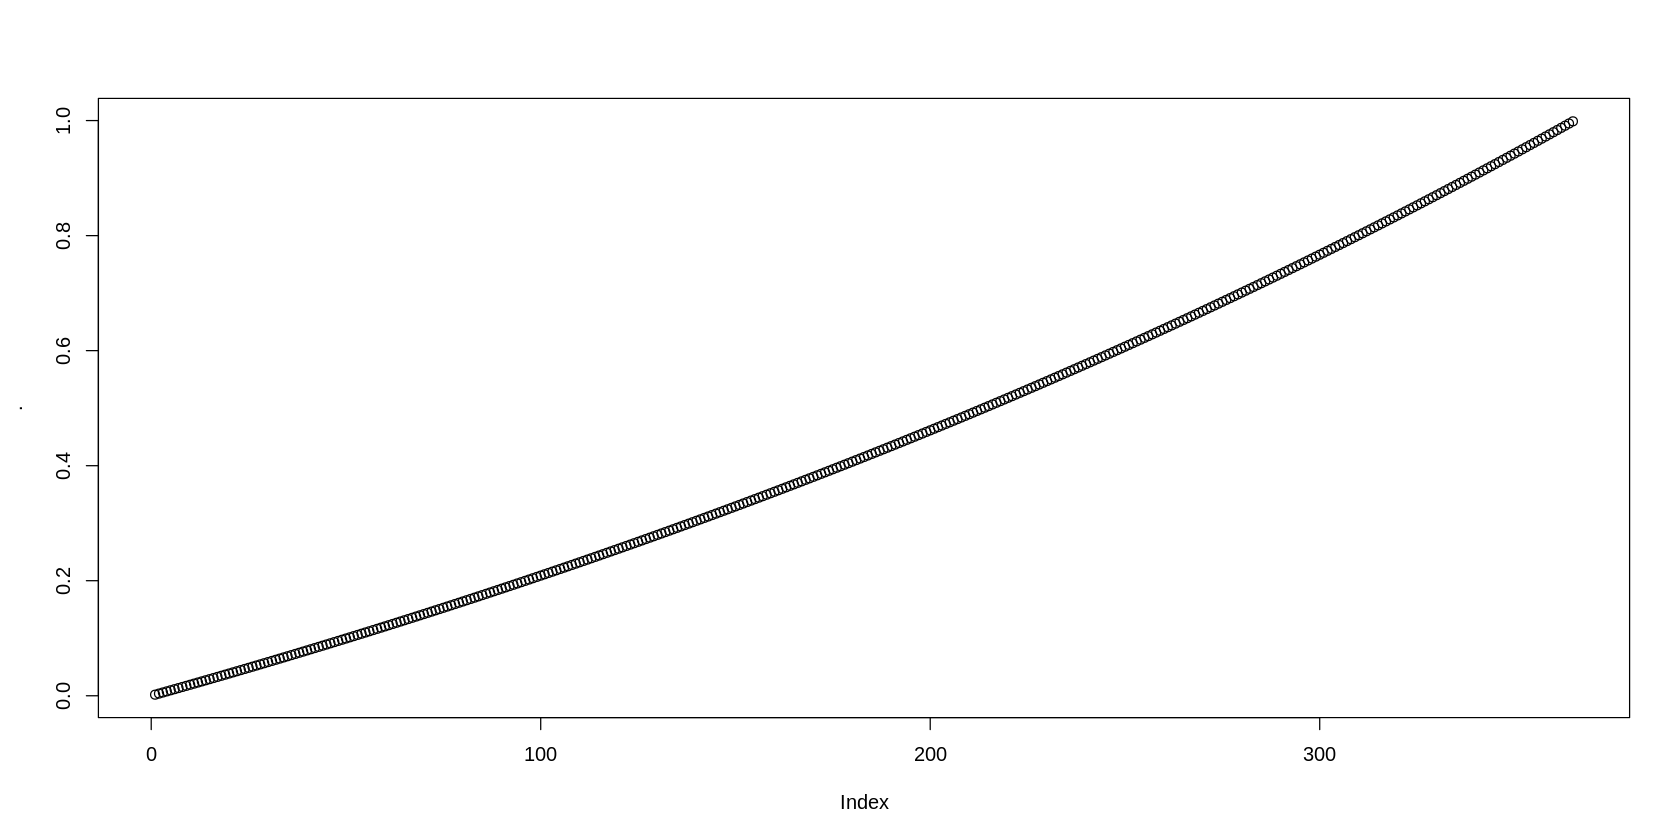

In [15]:
((1 + logreturn/365)^365) - 1
(cumprod(rep(1 + logreturn/365, 365)) - 1) %>% plot()

We're way closer. What if we compounded a million times?




In [16]:
((1 + logreturn/1e6)^1e6) - 1

[1] 0.9999995

There we go. A log return is the return that would get you to the final price, if you compounded continuously. (As much as you possibly can.)

## Adding up log returns over time

To chain log returns over time we can simply add them up 

$$rt = rt +  rt-1  . . .  + rt - n$$


In [17]:
log_returns <- log_returns %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    chained_log_returns = cumsum(log_return)
  ) %>%
  ungroup() %>%
  arrange(ticker,date) 

head(log_returns)

ticker,date,price_usd,market_cap,log_return,chained_log_returns
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-07-19,0.08080000,279285.2,-0.06050813,-0.06050813
BTC,2010-07-20,0.07473573,259000.4,-0.07801869,-0.13852682
BTC,2010-07-21,0.07919286,275266.5,0.05792790,-0.08059892
BTC,2010-07-22,0.05846976,203749.6,-0.30337647,-0.38397539
BTC,2010-07-23,0.06059287,211735.7,0.03566752,-0.34830787
BTC,2010-07-24,0.05454000,191100.0,-0.10524285,-0.45355072


# BTC Exploratory Data Analysis

Now let's do some exploratory data analysis on BTC returns.

Our first mission is to calculate some returns. We'll calculate both simple and log returns.

In [18]:
returns <- prices %>%
  mutate(
    log_return = log(price_usd / lag(price_usd)),
    simple_return = price_usd / lag(price_usd) - 1
  ) %>%
  na.omit()

head(returns)

ticker,date,price_usd,market_cap,log_return,simple_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-07-19,0.08080000,279285.2,-0.06050813,-0.05871389
BTC,2010-07-20,0.07473573,259000.4,-0.07801869,-0.07505286
BTC,2010-07-21,0.07919286,275266.5,0.05792790,0.05963859
BTC,2010-07-22,0.05846976,203749.6,-0.30337647,-0.26167891
BTC,2010-07-23,0.06059287,211735.7,0.03566752,0.03631124
BTC,2010-07-24,0.05454000,191100.0,-0.10524285,-0.09989409


### Histogram and density plot of log returns

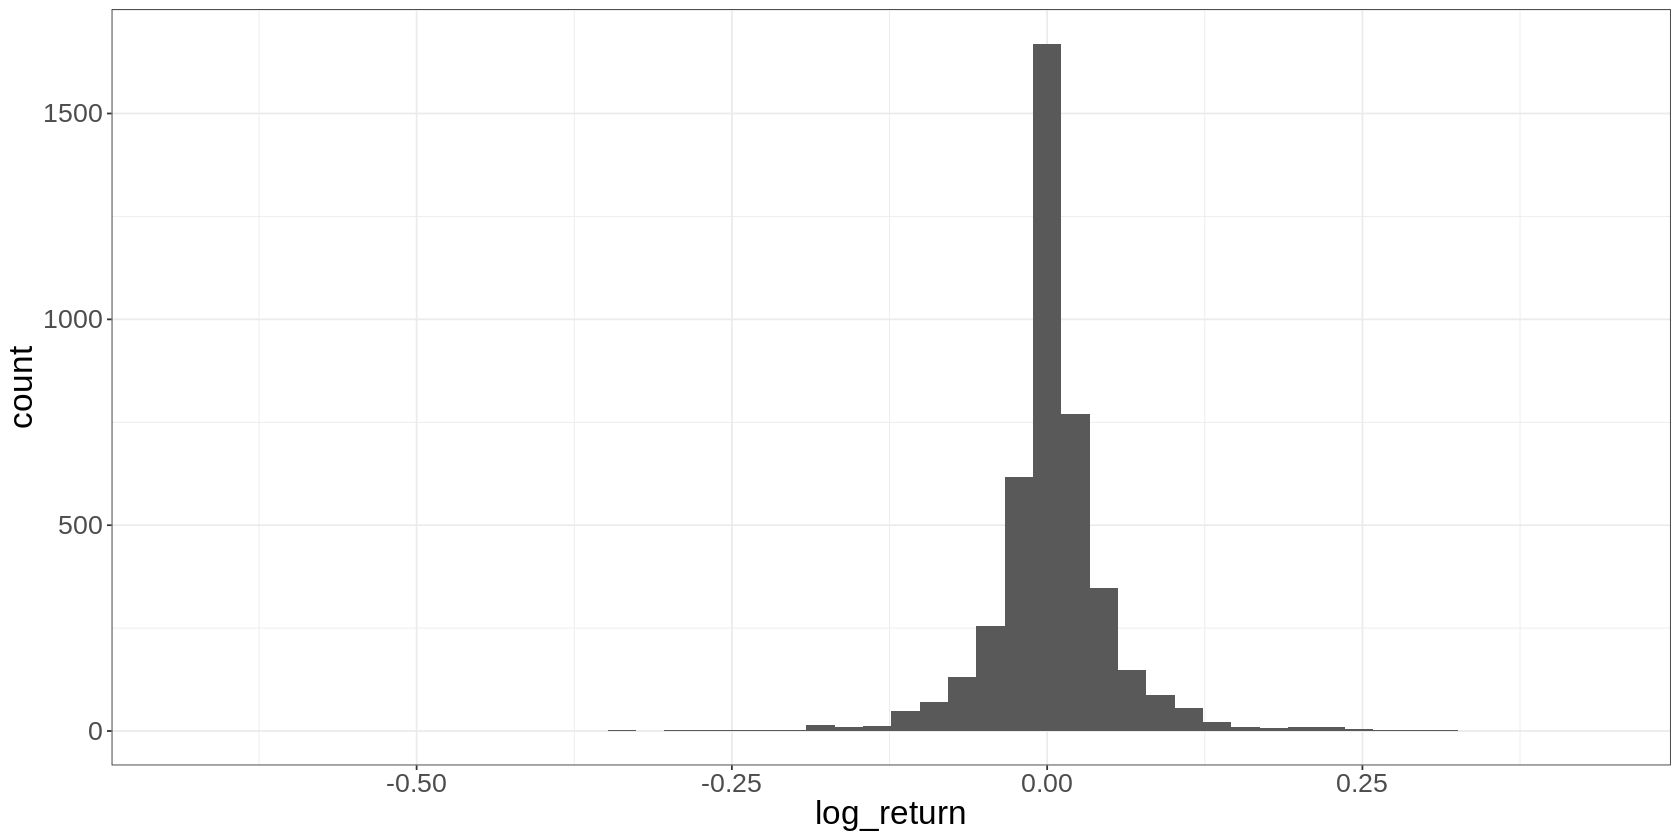

In [19]:
returns %>%
  ggplot(aes(x=log_return)) + geom_histogram(bins = 50)

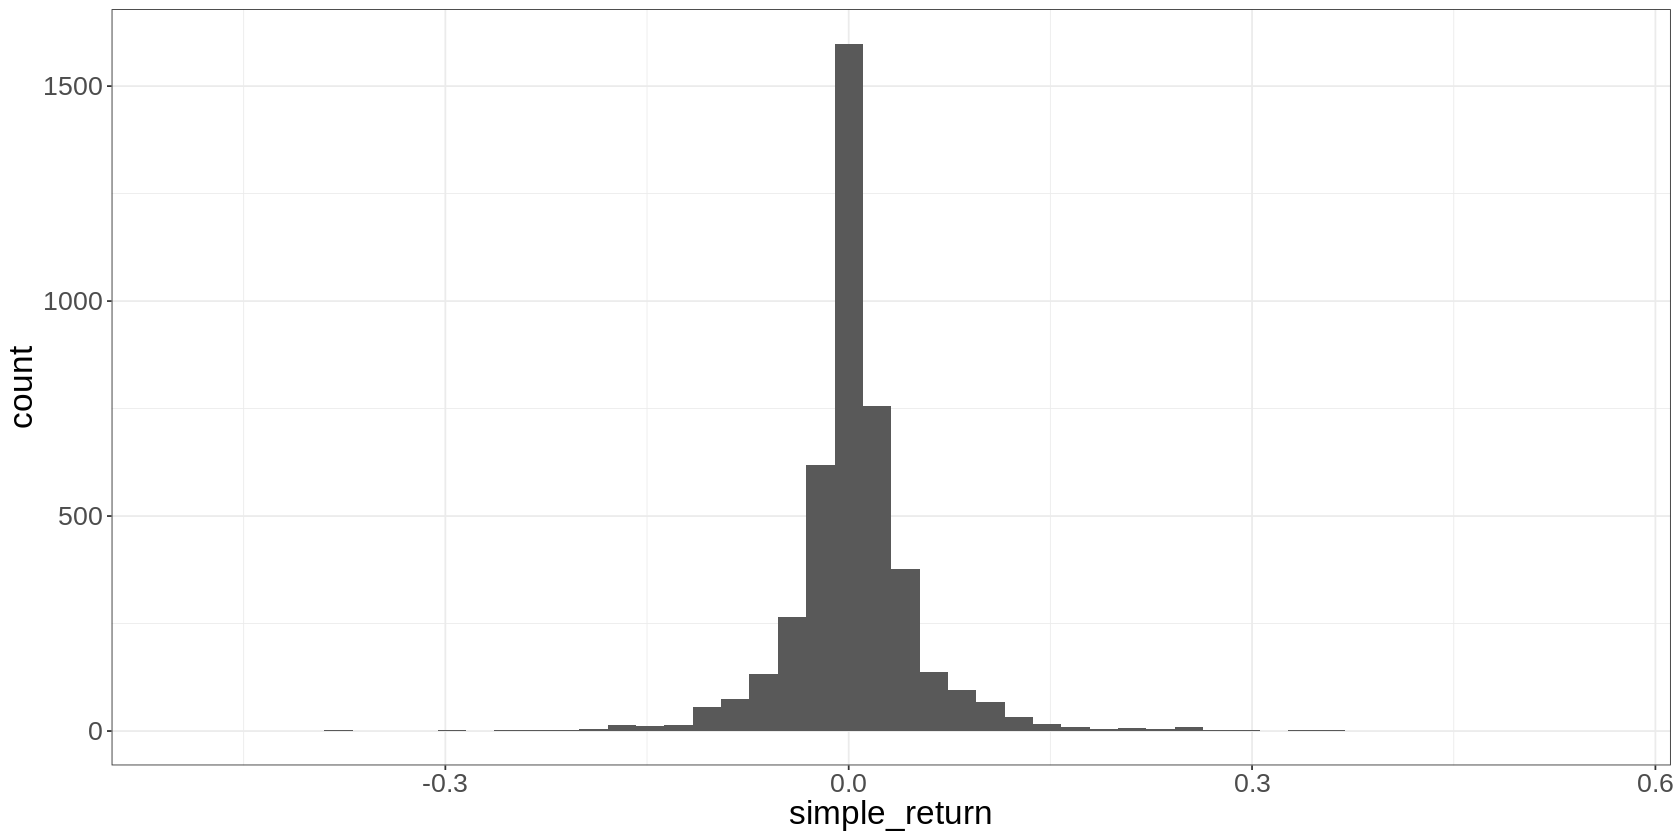

In [20]:
returns %>%
  ggplot(aes(x=simple_return)) + geom_histogram(bins = 50)

We can use code from the snippet library to compare the distribution to a normal distribution.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


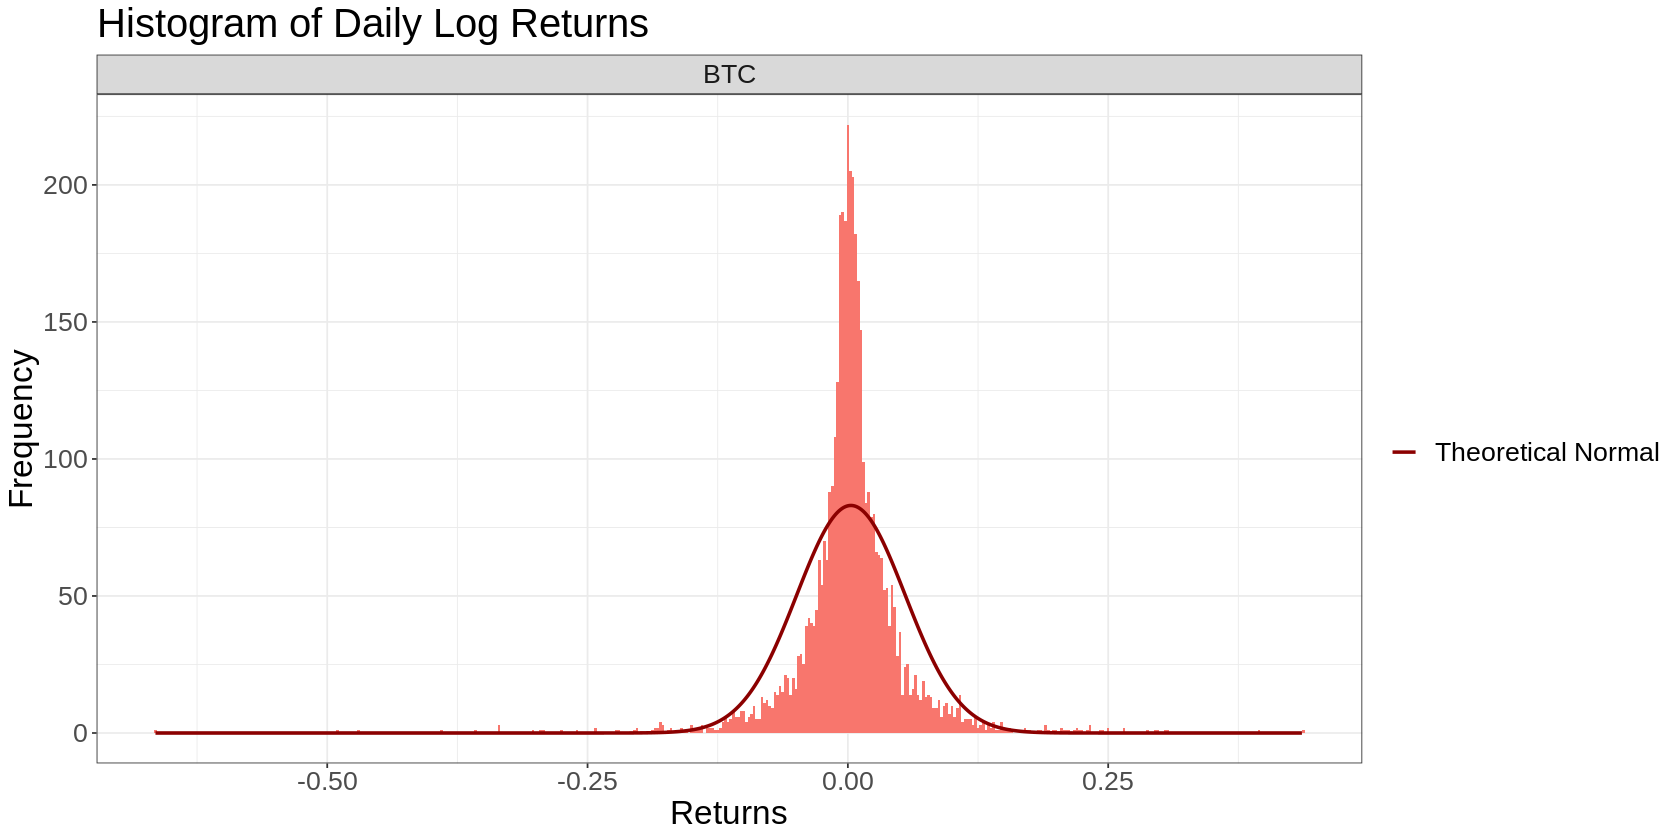

In [21]:
binwidth = 0.0025

#' derive theoretical normal distribution given mean and sd of a vector
theoretical_normal <- function(x, binwidth) {
  vec <- seq(from = min(x, na.rm = TRUE), to = max(x, na.rm = TRUE), by = 0.001)
  data.frame(theoretical_normal = binwidth*length(na.omit(x))*dnorm(vec, mean(x, na.rm = TRUE), sd = sd(x, na.rm = TRUE)), x = vec)
}

  
theo_norm <- returns %>% 
  group_by(ticker) %>%
  # .x exposes the subset of grouped data in group_modify
  group_modify(.f = ~theoretical_normal(.x$log_return, binwidth), .keep = TRUE) 

returns %>% 
  ggplot(aes(x = log_return, fill = ticker, group = ticker)) +
    geom_histogram(binwidth = binwidth) +
    geom_line(data = theo_norm, aes(x = x, y = theoretical_normal, colour = "Theoretical Normal"), size = 1.) +
    scale_colour_manual("", values = "darkred") +
    facet_wrap(~ticker, scales = "free") +
    labs(
      x = "Returns",
      y = "Frequency",
      title = "Histogram of Daily Log Returns"
    ) +
    guides(fill = FALSE)

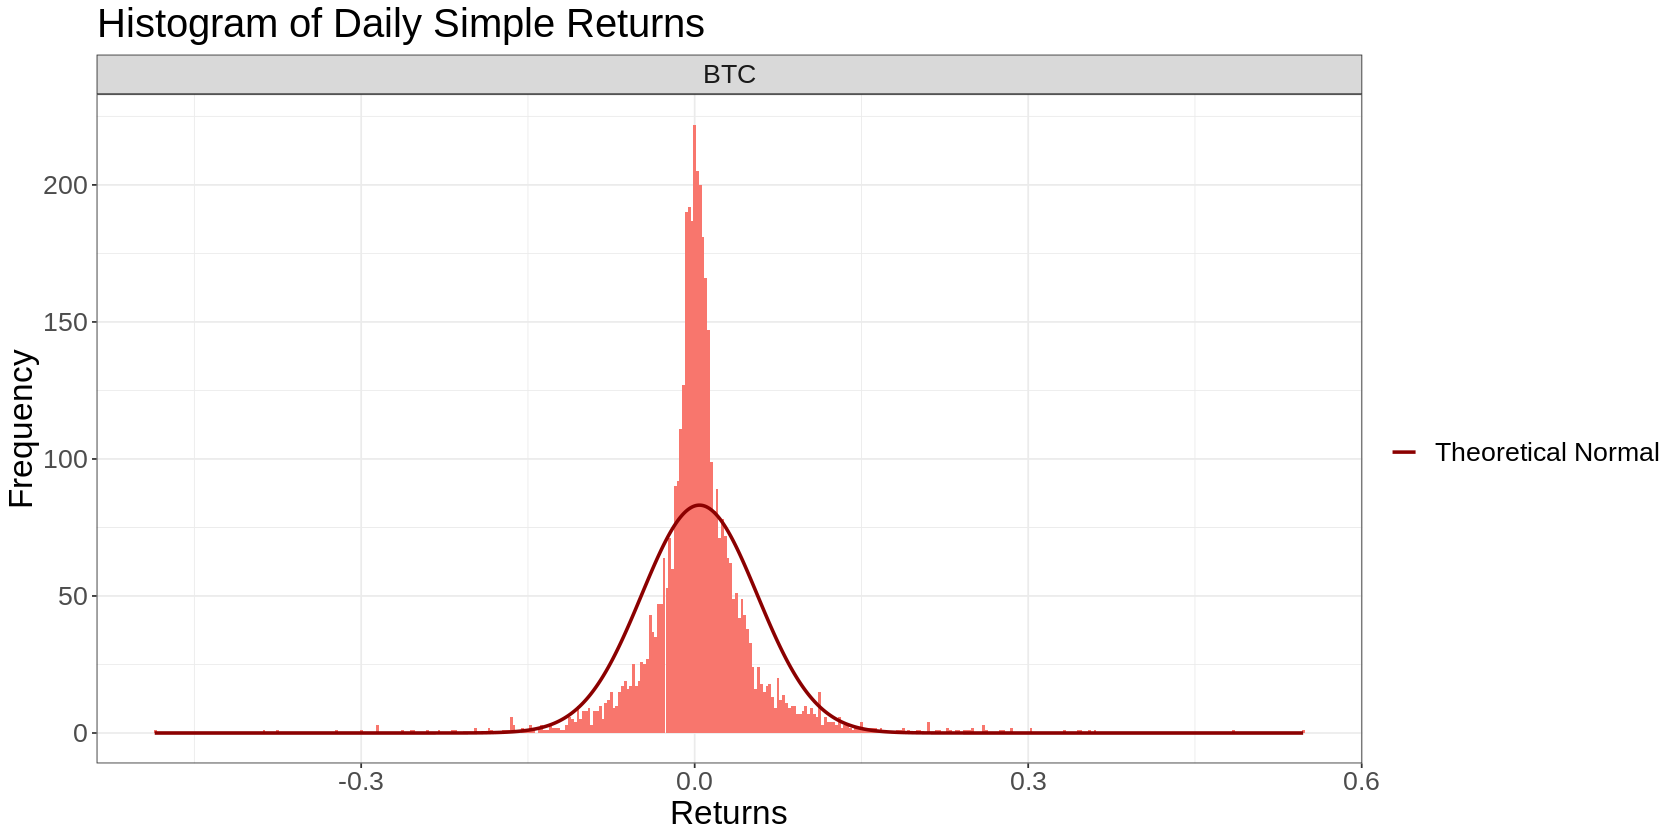

In [22]:
theo_norm <- returns %>% 
  group_by(ticker) %>%
  # .x exposes the subset of grouped data in group_modify
  group_modify(.f = ~theoretical_normal(.x$simple_return, binwidth), .keep = TRUE) 

returns %>% 
  ggplot(aes(x = simple_return, fill = ticker, group = ticker)) +
    geom_histogram(binwidth = binwidth) +
    geom_line(data = theo_norm, aes(x = x, y = theoretical_normal, colour = "Theoretical Normal"), size = 1.) +
    scale_colour_manual("", values = "darkred") +
    facet_wrap(~ticker, scales = "free") +
    labs(
      x = "Returns",
      y = "Frequency",
      title = "Histogram of Daily Simple Returns"
    ) +
    guides(fill = FALSE)

Daily BTC log returns have:


* positive mean  
* fat tails 
* negative skew



It is often useful to subset our data to see if we observe changes over time.

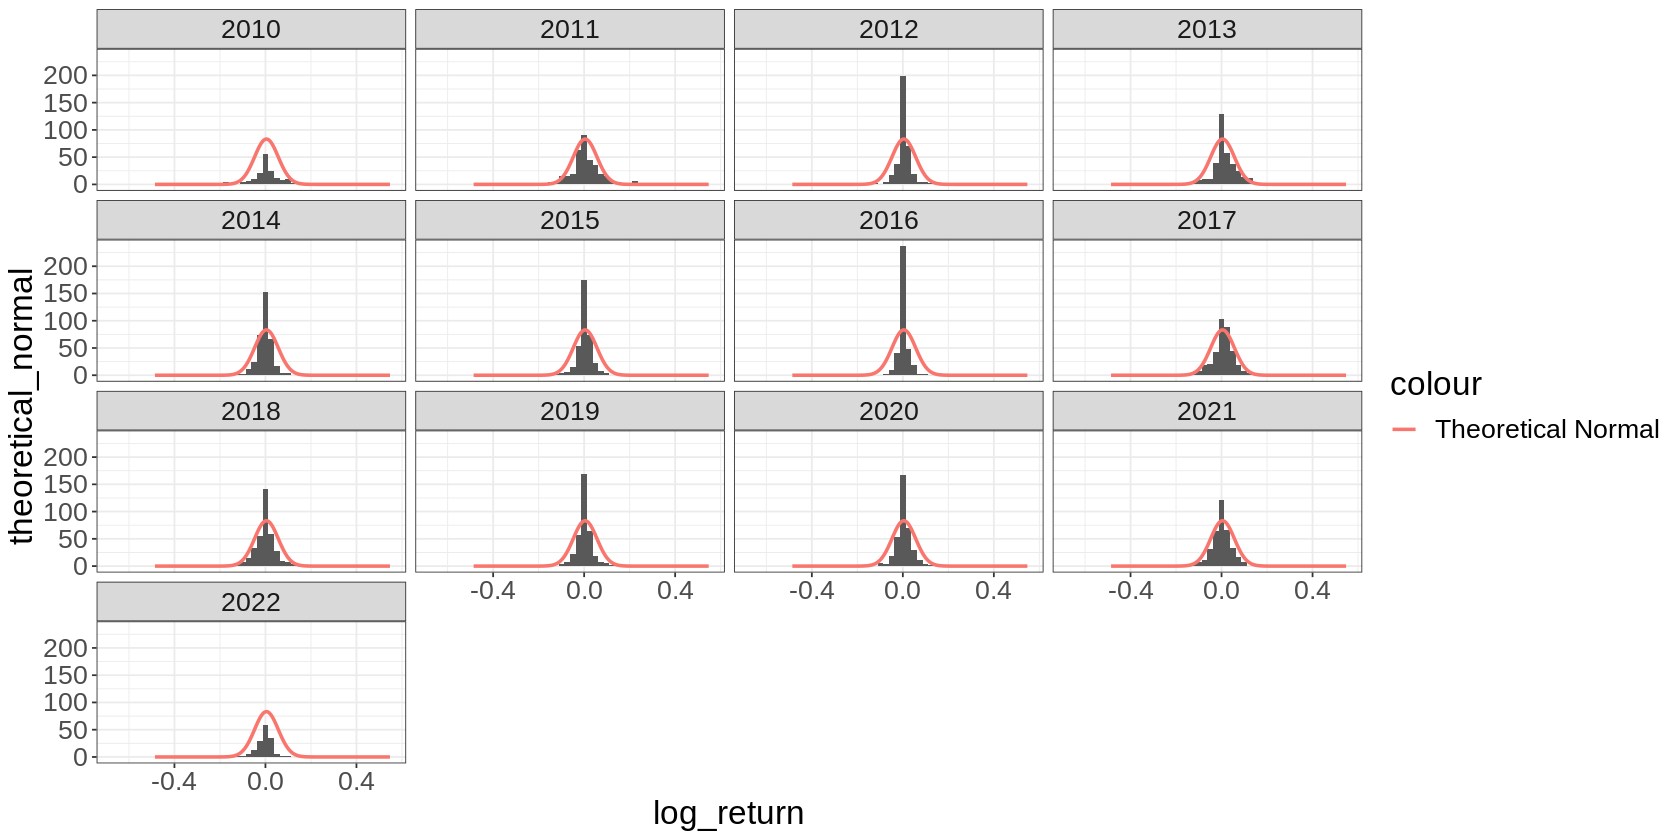

In [23]:
returns %>% 
  mutate(year = year(date))  %>%
  group_by(year) %>%
  ggplot(aes(x = log_return)) +
    geom_histogram(bins = 50) +
    geom_line(data = theo_norm, aes(x = x, y = theoretical_normal, colour = "Theoretical Normal"), size = 1.) +
    facet_wrap(~year)

### Autocorrelation of returns

Now we look for signs of trend or auto-correlation in returns.

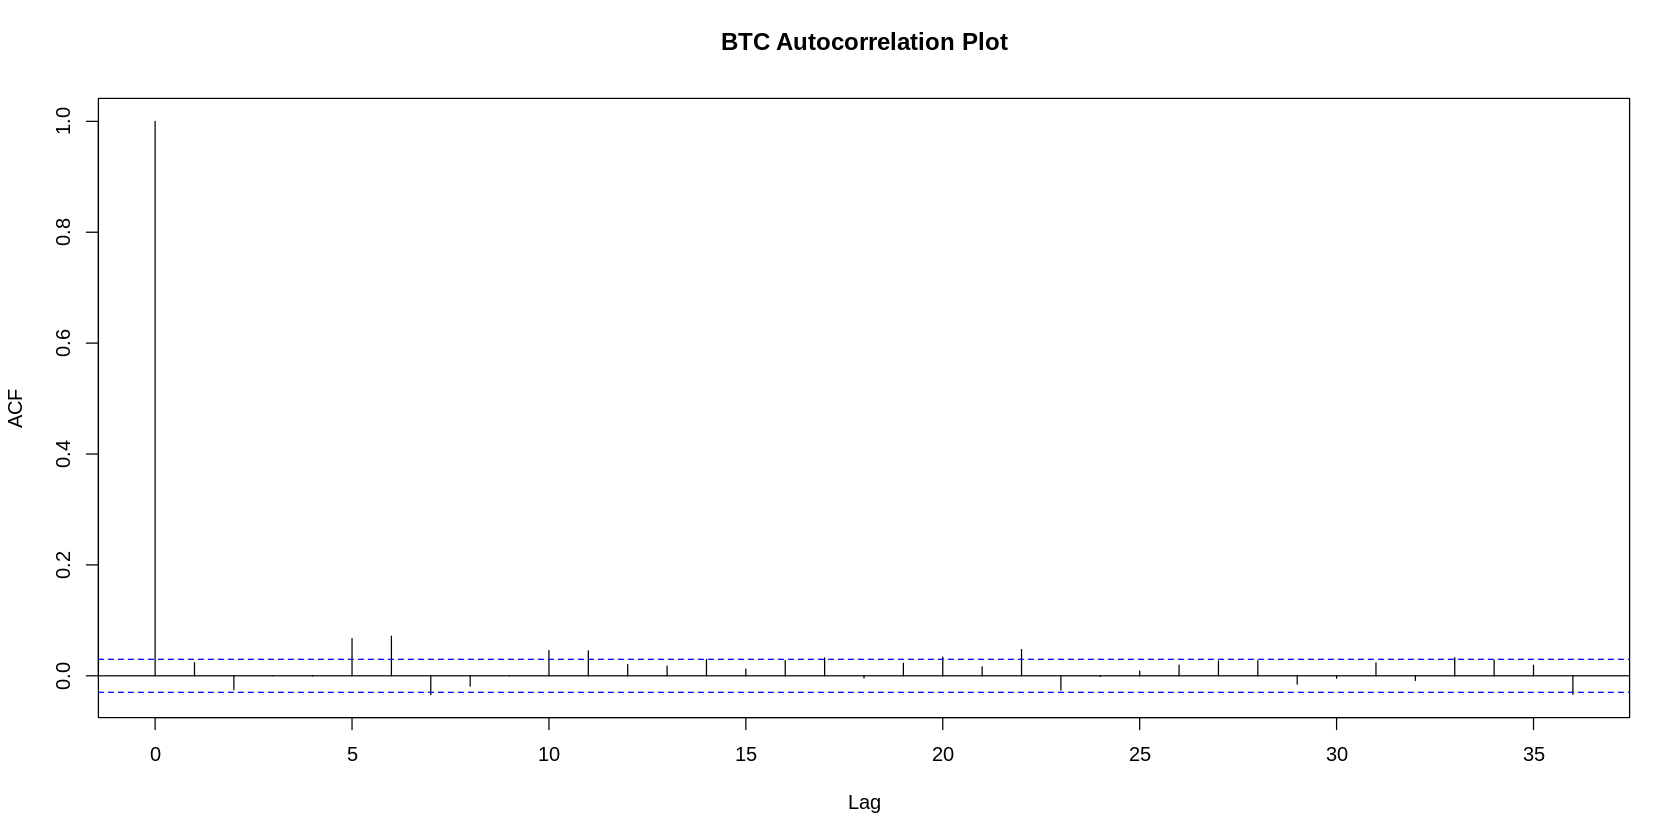

In [24]:
plot(acf(returns$log_return,plot=FALSE),main="BTC Autocorrelation Plot")

No clear signs of auto-correlation there... What about in the early years?

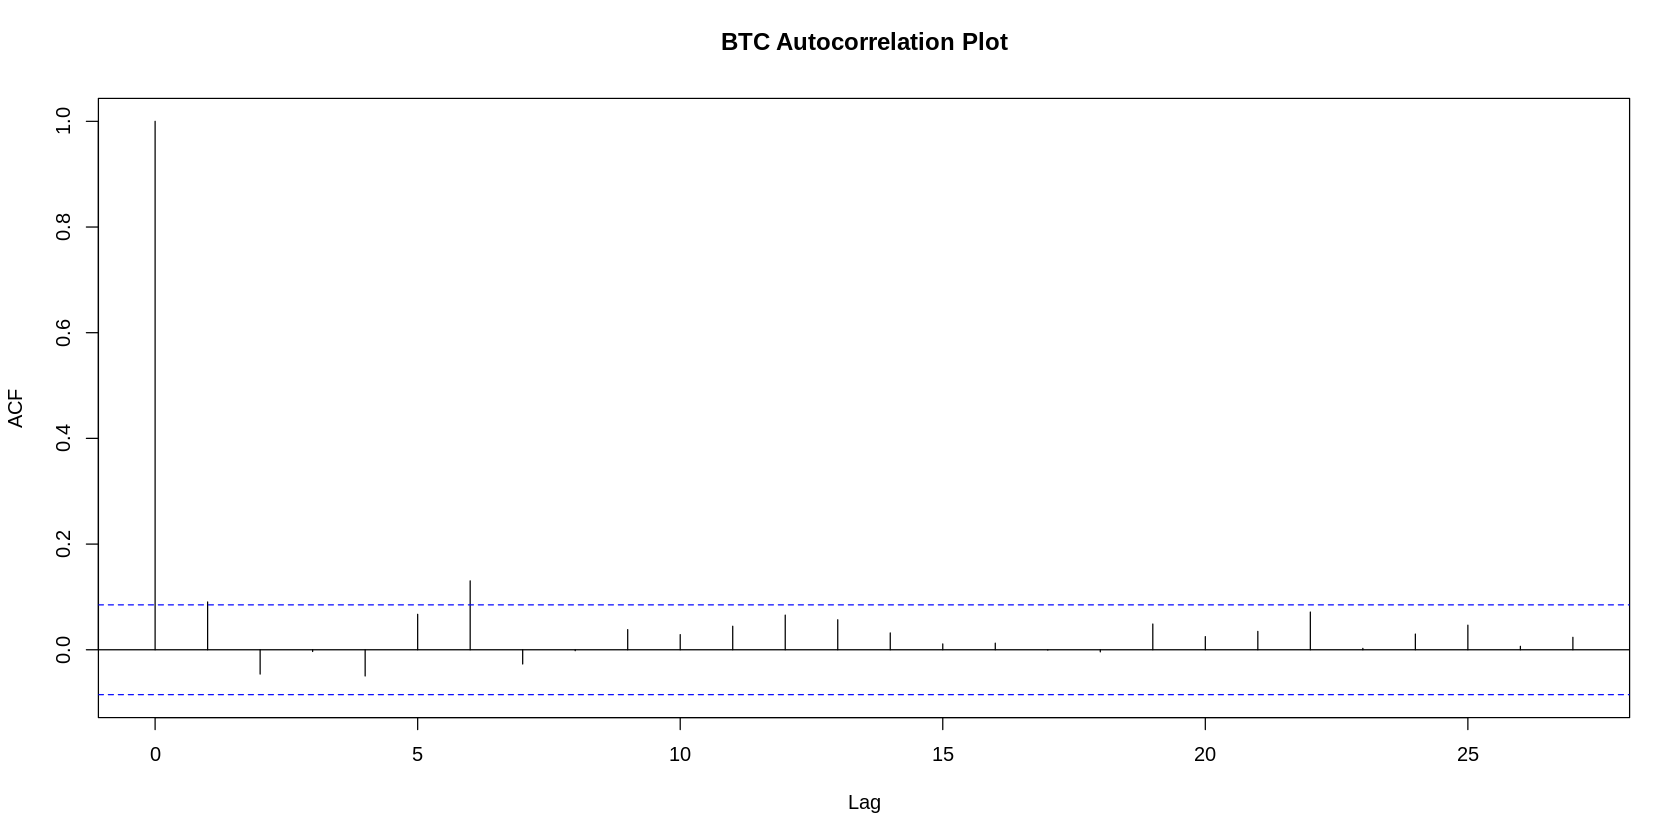

In [25]:
plot(acf(filter(returns, date <= '2012-01-01')$log_return,plot=FALSE),main="BTC Autocorrelation Plot")

Perhaps just a tiny whiff of trend effects.

What about since 2020?

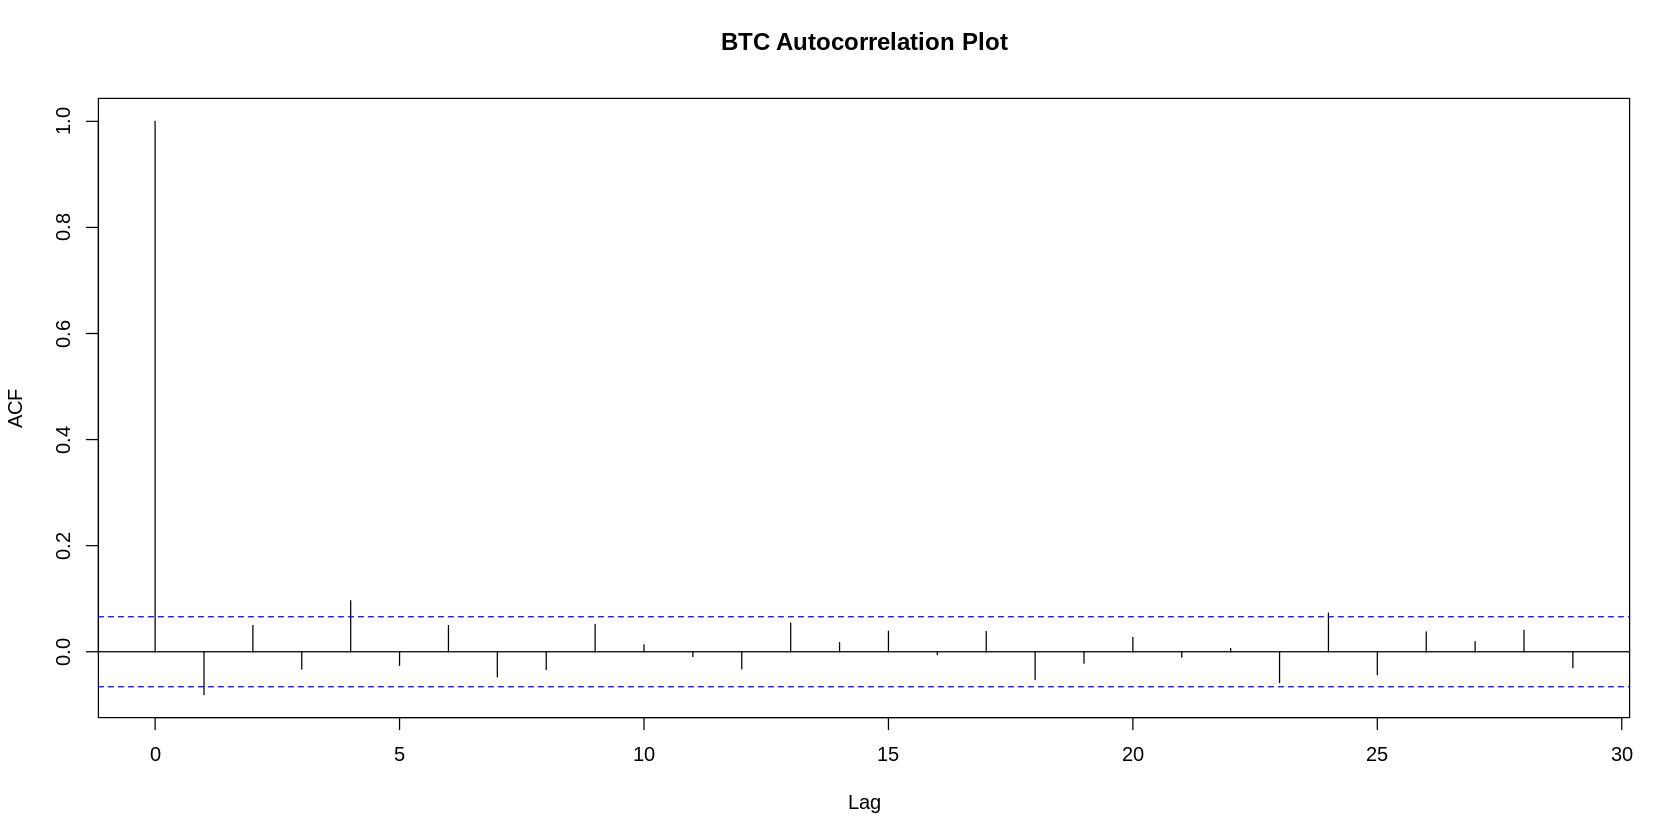

In [26]:
plot(acf(filter(returns, date > '2020-01-01')$log_return,plot=FALSE),main="BTC Autocorrelation Plot")

Hints of statistically significant reversal effects - maybe random, maybe due to pressures from hedging growing option positions.

### Scatterplot

After the histogram, the scatterplot is probably the visualisation tool you will use the most iin your analysis.

It allows us to visualise the relationship between two variables.

`geom_smooth()` using formula = 'y ~ x'


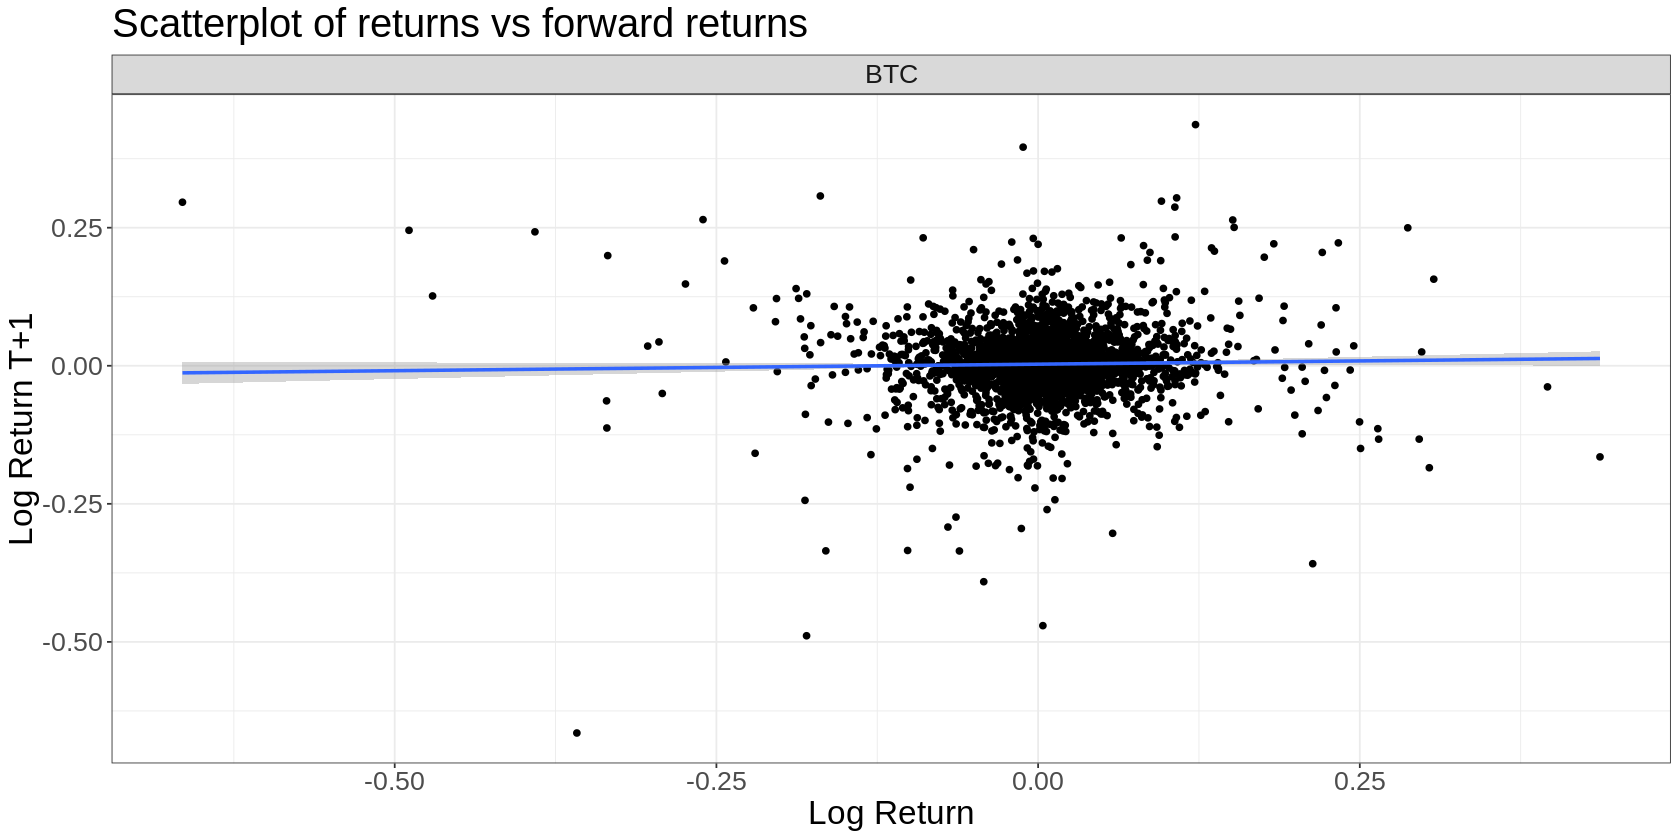

In [27]:
returns %>%
  arrange(date) %>%
  mutate(future_ret = lead(log_return, 1)) %>%
  na.omit() %>% 
  ggplot(aes(x = log_return, y = future_ret)) + 
    geom_point() +
    geom_smooth(method = 'lm') + 
    facet_wrap(~ticker, scales = 'free') +
    labs(
      title = 'Scatterplot of returns vs forward returns',
      x = 'Log Return',
      y = 'Log Return T+1'
    )

### Conditional return distributions

In trading, our most common problem is "do things look different conditional on this variable?"

We can look at that by:


*   conditioning or ranking return observations by a variable
*   plotting or summarising the conditional return distribution



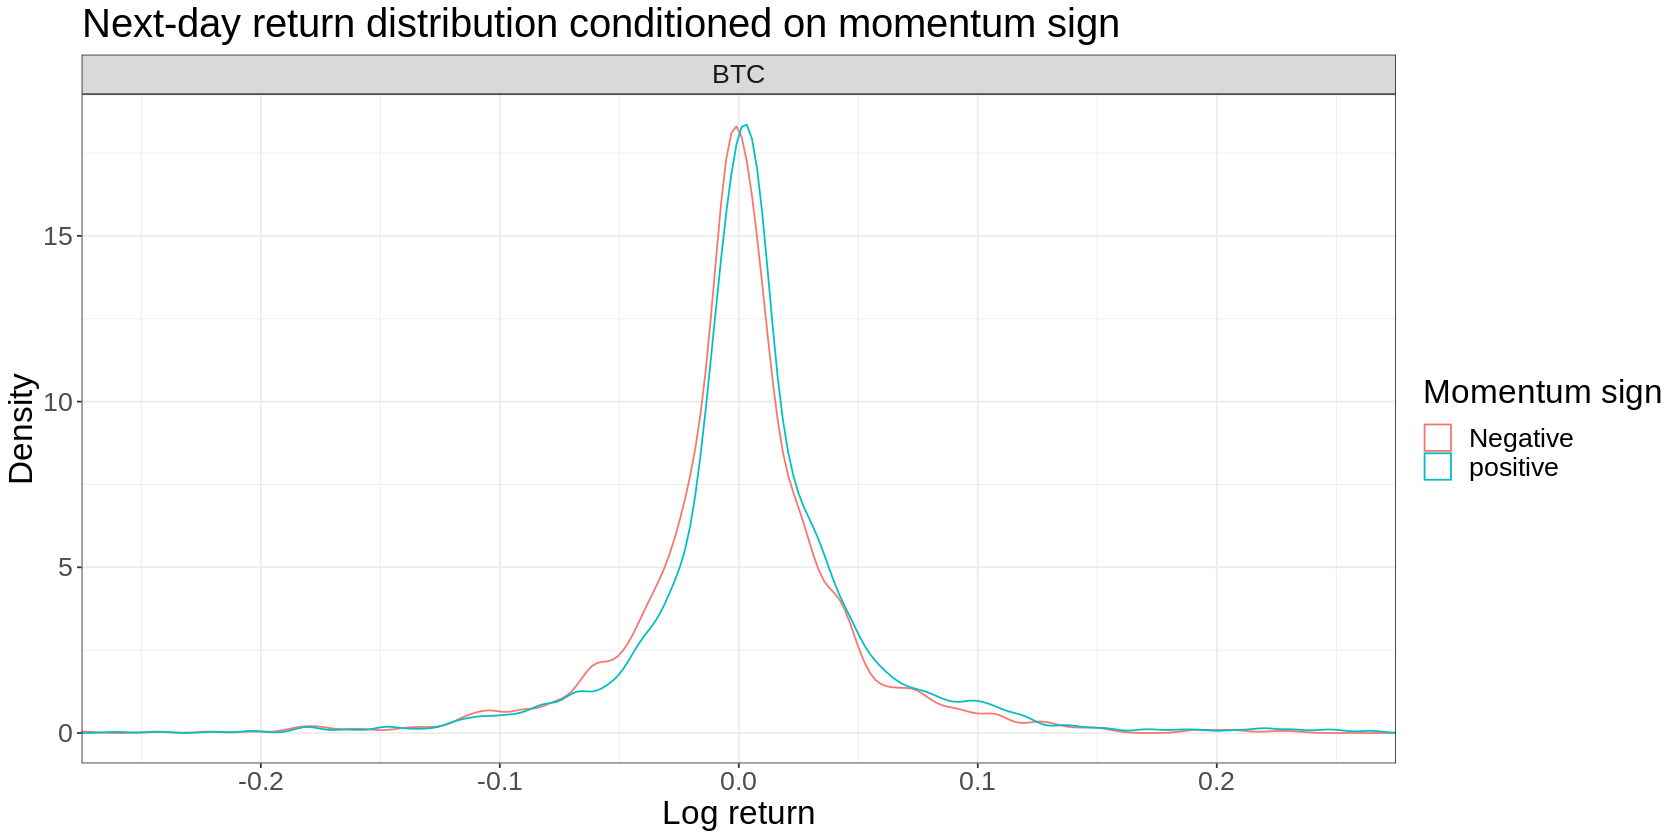

In [28]:
returns %>%
  arrange(date) %>%
  mutate(
    momo = price_usd - lag(price_usd, n = 30), 
    fwd_return = log(lead(price_usd, n = 2)/lead(price_usd, n = 1)),
    momo_sign = case_when(momo < 0 ~ "Negative", TRUE ~ "positive")
  ) %>%
  na.omit() %>%
  ggplot(aes(x = fwd_return, colour = momo_sign)) +
    geom_density() +
    facet_wrap(~ticker) +
    coord_cartesian(xlim = c(-0.25, 0.25)) +
    labs(
      x = "Log return",
      y = "Density",
      title = "Next-day return distribution conditioned on momentum sign",
      colour = "Momentum sign"
    )


We do see some evidence that negative momentum is associated with more negative and more negatively skewed 1-day returns, and vice versa. 

The effect is perhaps more tangible if we summarise by conditioning mean next-day return on momentum sign:


`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


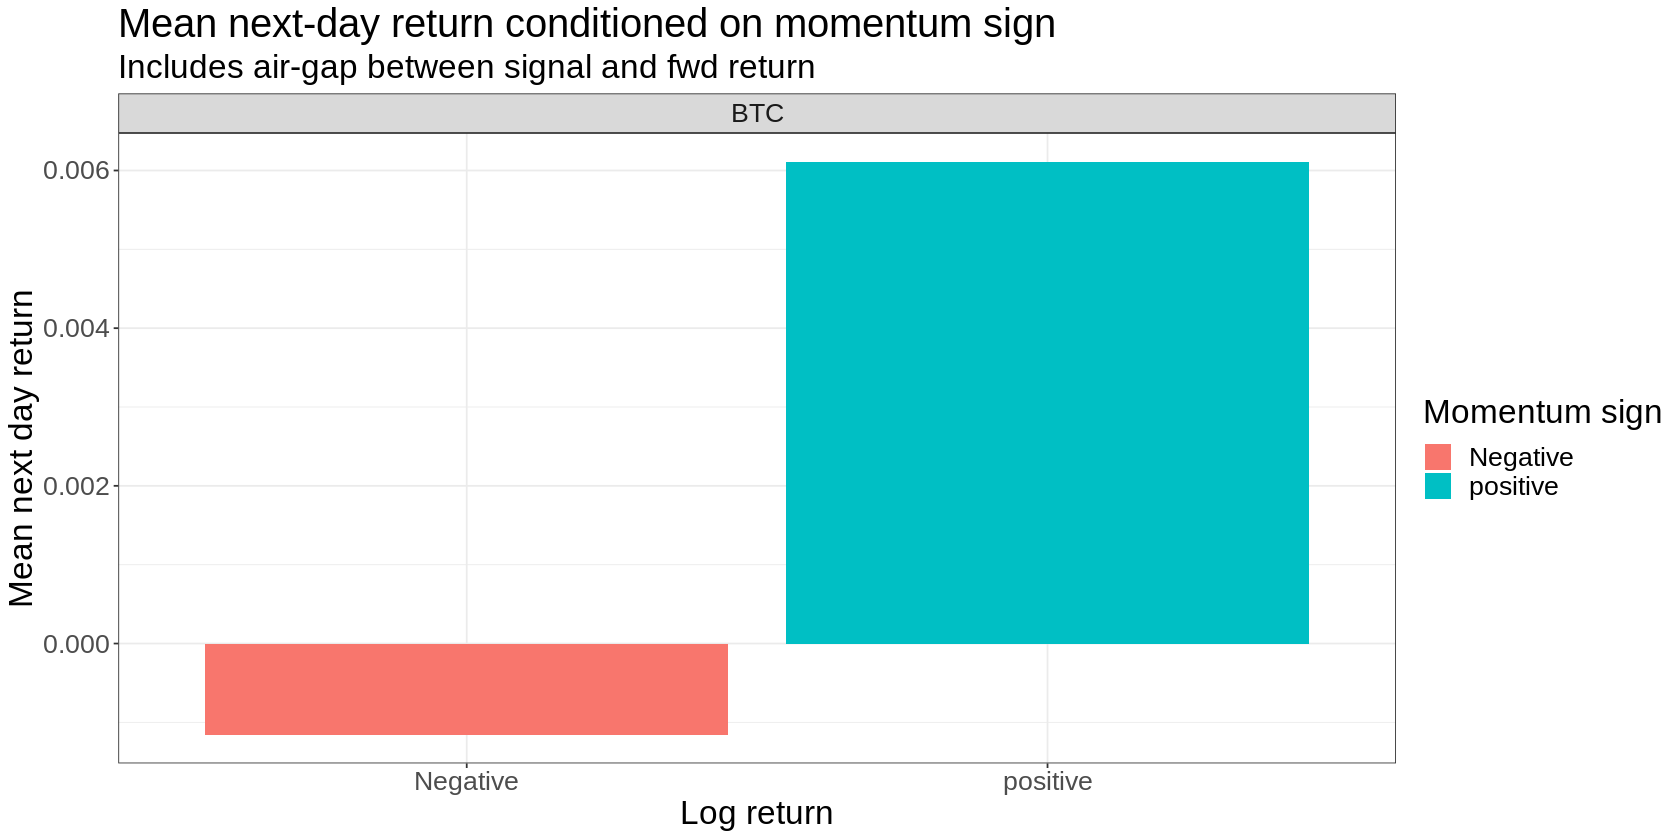

In [29]:
returns %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    momo = price_usd - lag(price_usd, n = 30), 
    fwd_return = log(lead(price_usd, n = 2)/lead(price_usd, n = 1)),
    momo_sign = case_when(momo < 0 ~ "Negative", TRUE ~ "positive")
  ) %>%
  na.omit() %>%
  group_by(ticker, momo_sign) %>%
  summarise(mean_fwd_return = mean(fwd_return, na.rm = TRUE)) %>%
  ggplot(aes(y = mean_fwd_return, x = momo_sign, fill = momo_sign)) +
    geom_bar(stat = 'identity') +
    facet_wrap(~ticker) +
    labs(
      x = "Log return",
      y = "Mean next day return",
      title = "Mean next-day return conditioned on momentum sign",
      subtitle = "Includes air-gap between signal and fwd return",
      fill = "Momentum sign"
    )

Looking over a 5-day forward horizon:

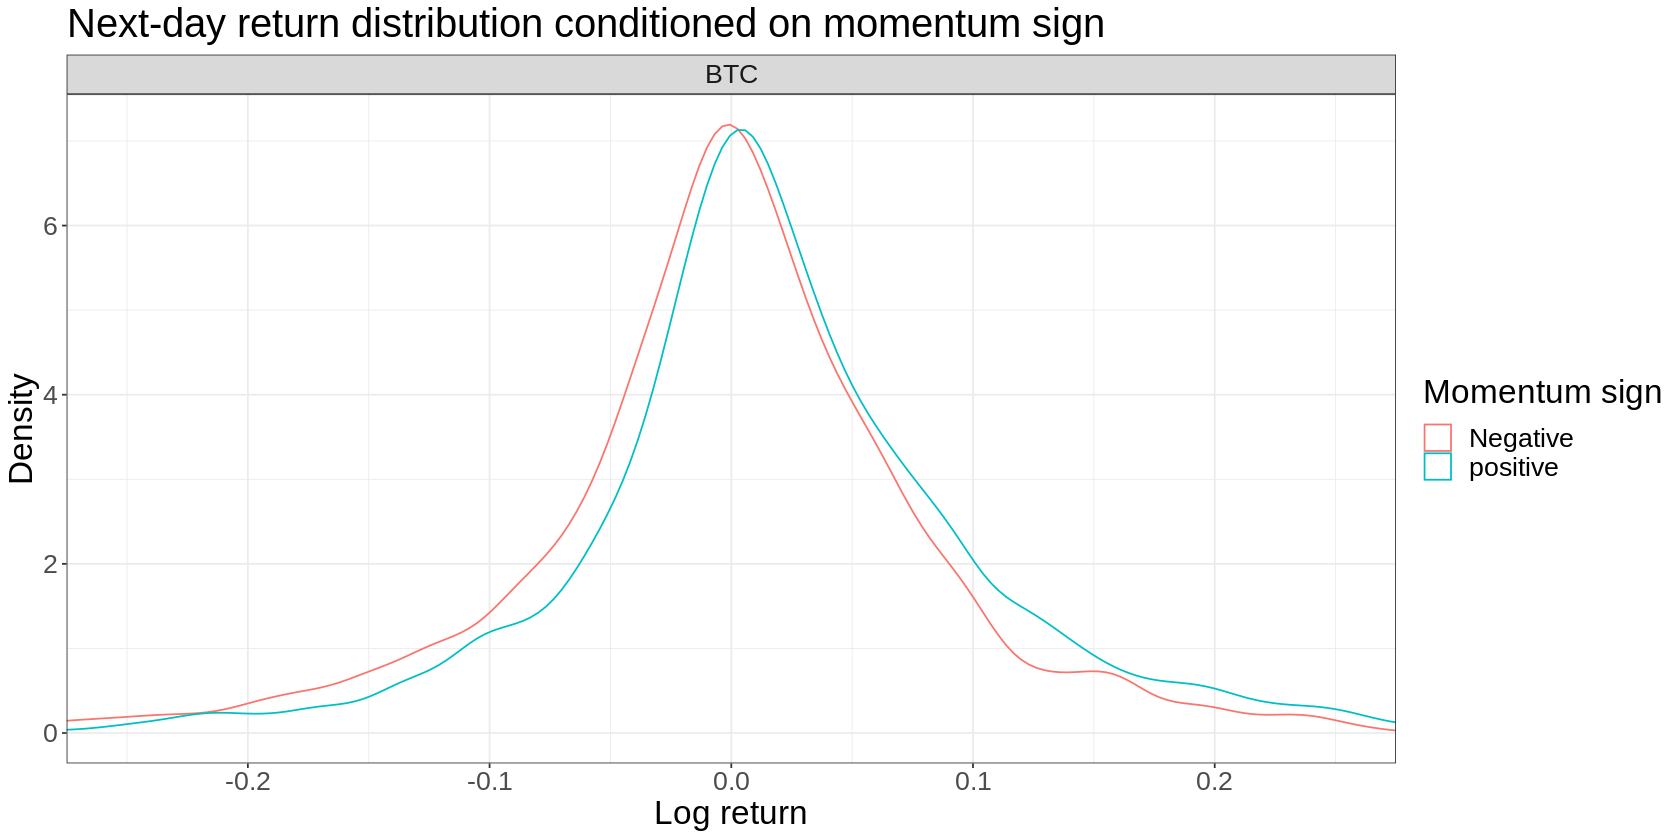

In [30]:
returns %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    momo = price_usd - lag(price_usd, n = 30), 
    fwd_return = log(lead(price_usd, n = 5)/lead(price_usd, n = 1)),
    momo_sign = case_when(momo < 0 ~ "Negative", TRUE ~ "positive")
  ) %>%
  na.omit() %>%
  ggplot(aes(x = fwd_return, colour = momo_sign)) +
    geom_density() +
    facet_wrap(~ticker) +
    coord_cartesian(xlim = c(-0.25, 0.25)) +
    labs(
      x = "Log return",
      y = "Density",
      title = "Next-day return distribution conditioned on momentum sign",
      colour = "Momentum sign"
    )


Again summarising:

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


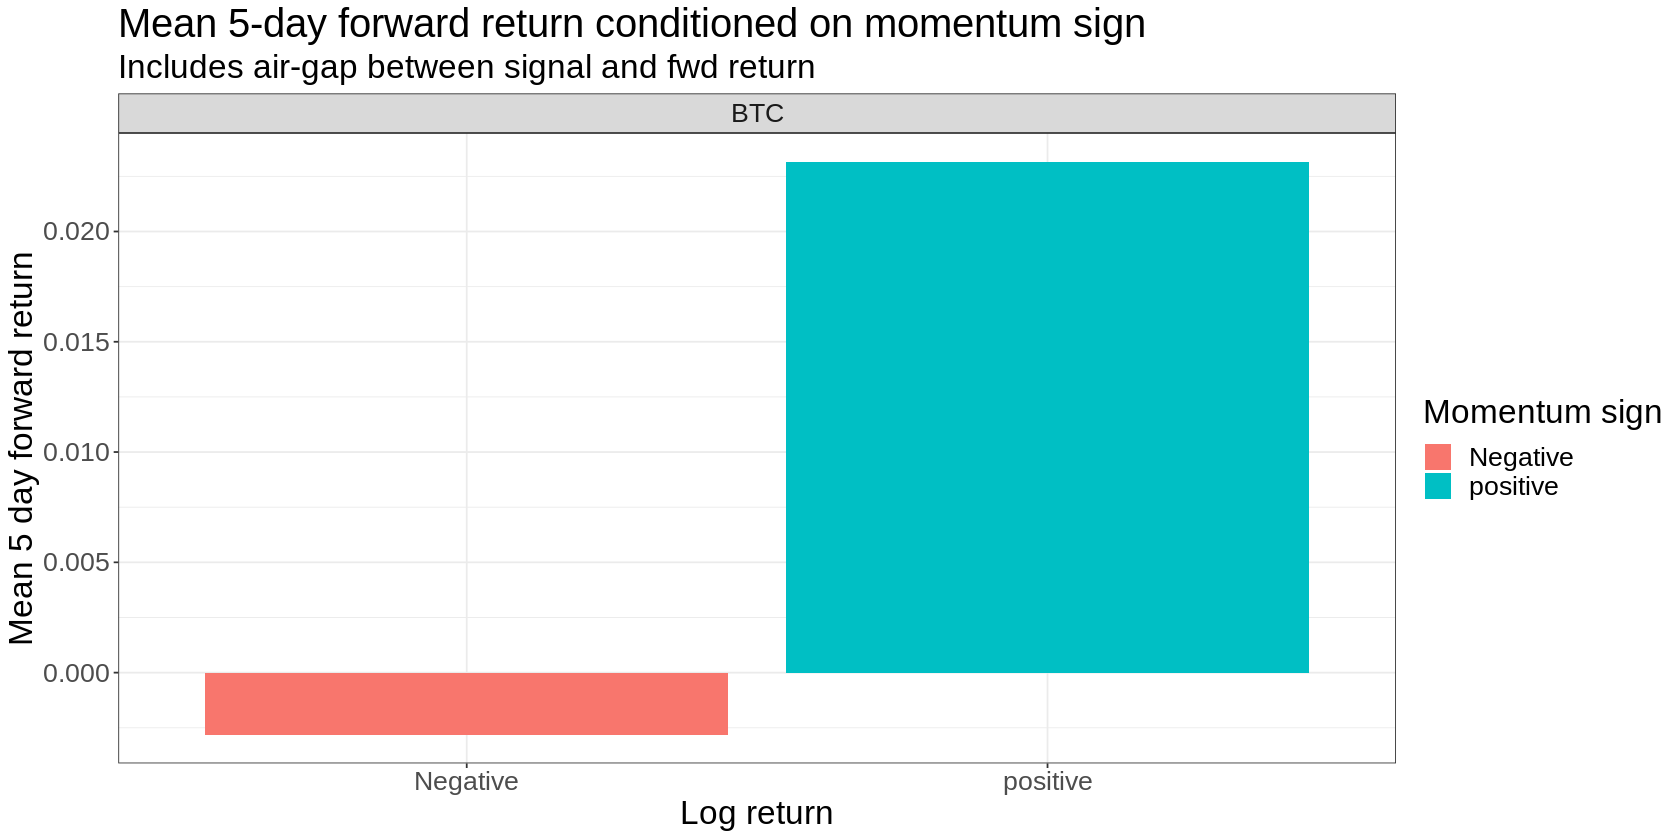

In [31]:
returns %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    momo = price_usd - lag(price_usd, n = 30), 
    fwd_return = log(lead(price_usd, n = 5)/lead(price_usd, n = 1)),
    momo_sign = case_when(momo < 0 ~ "Negative", TRUE ~ "positive")
  ) %>%
  na.omit() %>%
  group_by(ticker, momo_sign) %>%
  summarise(mean_fwd_return = mean(fwd_return, na.rm = TRUE)) %>%
  ggplot(aes(y = mean_fwd_return, x = momo_sign, fill = momo_sign)) +
    geom_bar(stat = 'identity') +
    facet_wrap(~ticker) +
    labs(
      x = "Log return",
      y = "Mean 5 day forward return",
      title = "Mean 5-day forward return conditioned on momentum sign",
      subtitle = "Includes air-gap between signal and fwd return",
      fill = "Momentum sign"
    )

### Seasonal Return Patterns

Are there monthly and/or weekly seasonal patterns in crypto returns?

We don't have a lot of data for a monthly analysis, so let's take this with a grain of salt.

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


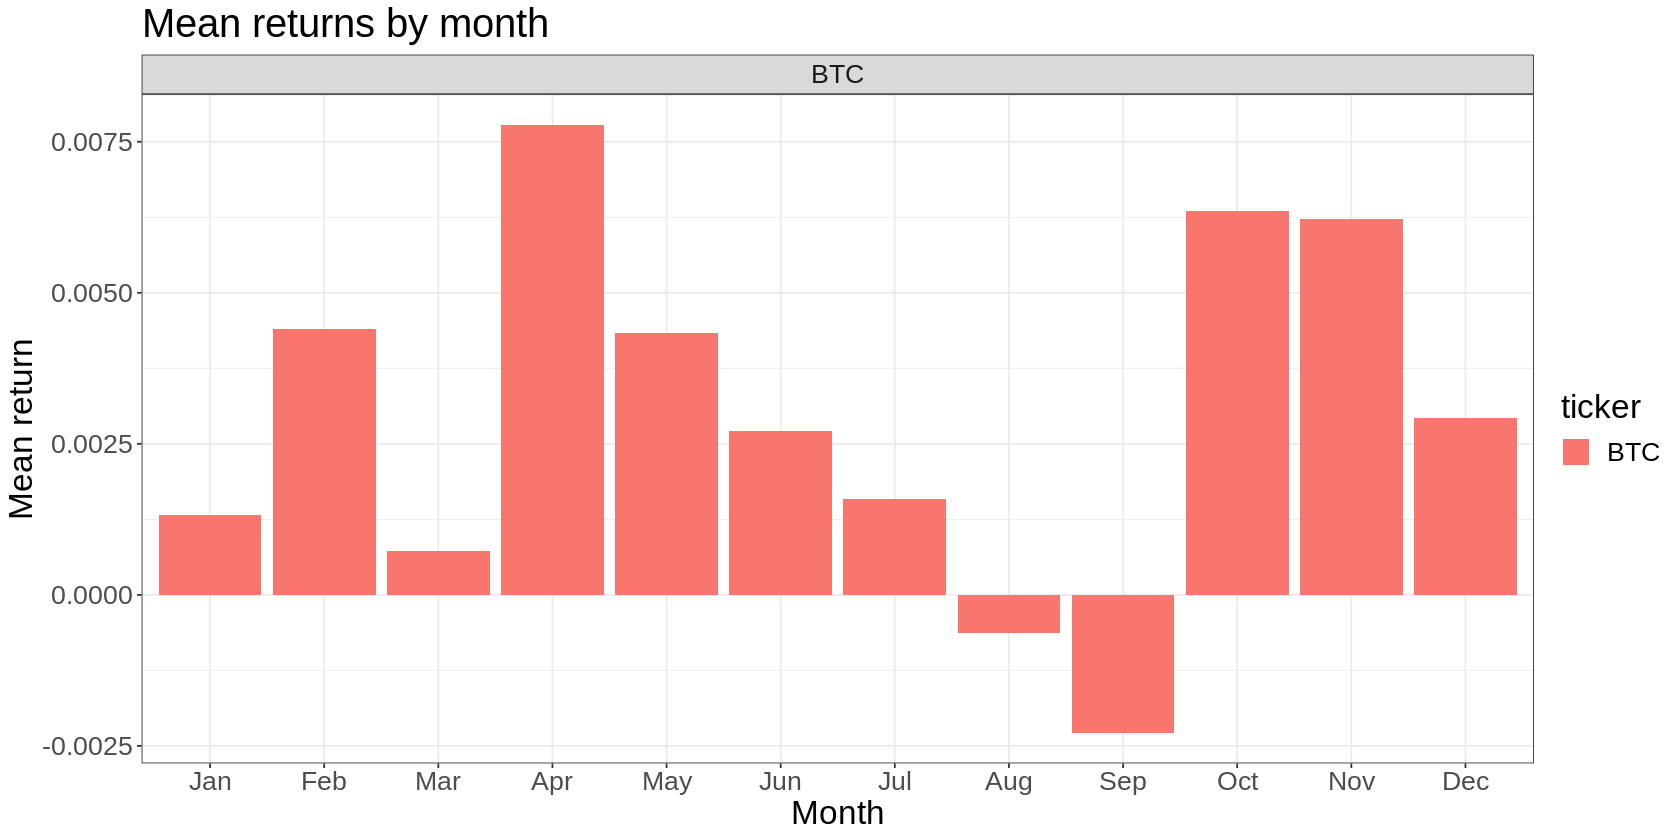

In [32]:
returns %>%
  mutate(month = factor(month(date, label = TRUE))) %>% 
  group_by(ticker, month) %>%
  summarise(mean_return = mean(log_return, na.rm = TRUE)) %>%
  ggplot(aes(x = month, y = mean_return, fill = ticker)) +
    geom_bar(stat = 'identity', position = position_dodge()) +
    labs(
      title = 'Mean returns by month', 
      x = 'Month', 
      y = 'Mean return') +
    facet_wrap(~ticker) 

Cautious to draw any conclusions given how little data we have. 

We have more data available if we explore day-of-week seasonality:

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


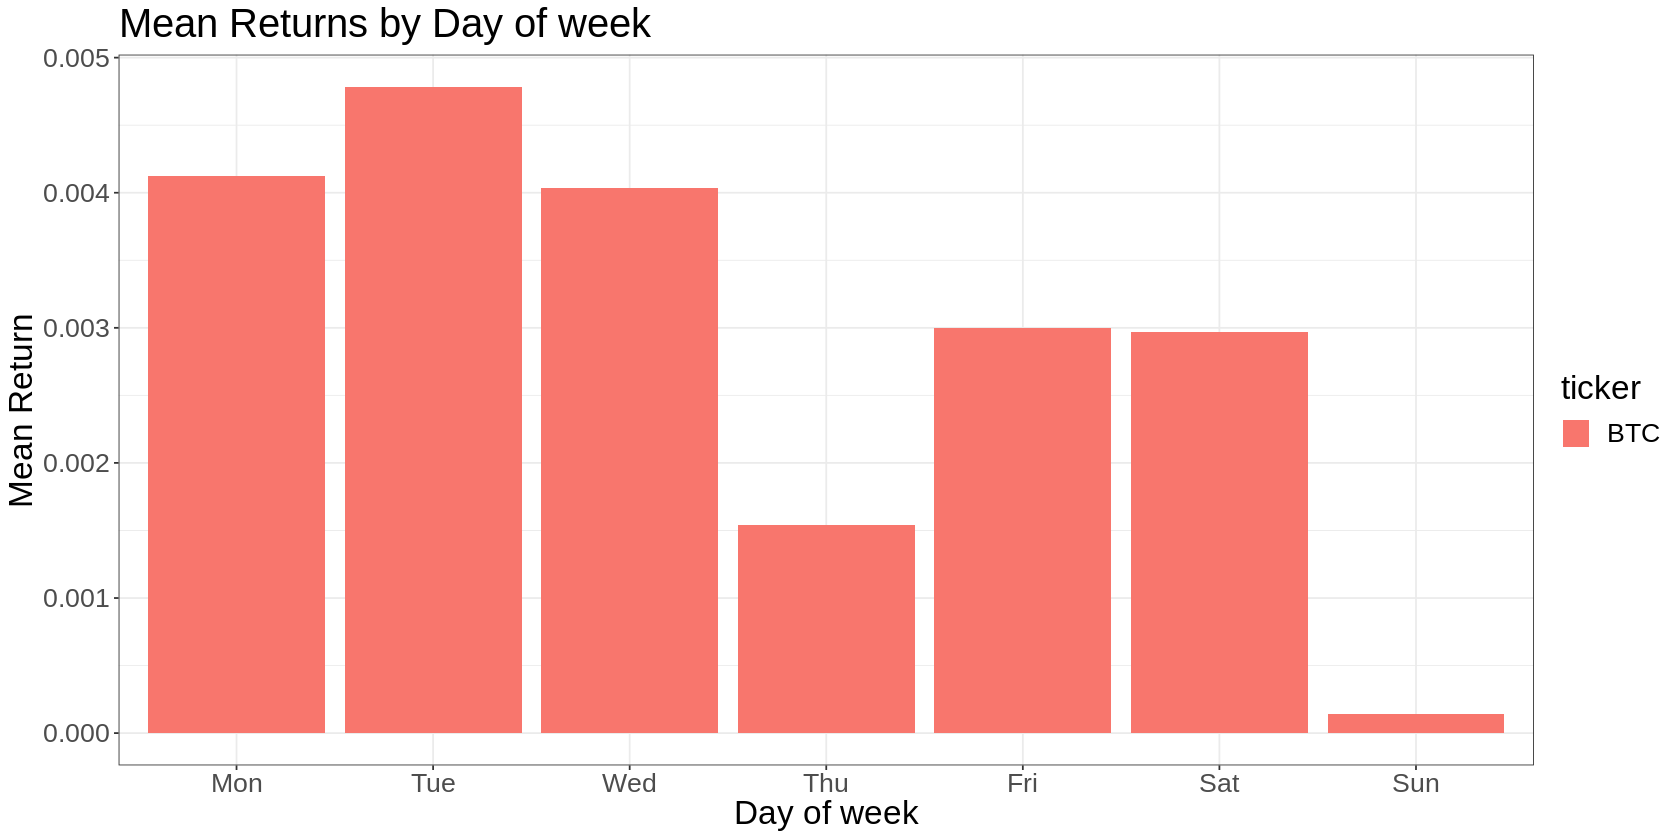

In [33]:
returns %>%
  mutate(day = factor(weekdays(date, abbreviate = TRUE), ordered = TRUE, levels = c('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))) %>% 
  group_by(ticker, day) %>%
  summarise(mean_return = mean(log_return, na.rm = TRUE)) %>%
  ggplot(aes(x = day, y = mean_return, fill = ticker)) +
    geom_bar(stat = 'identity', position = position_dodge()) +
    labs(
      title = 'Mean Returns by Day of week', 
      x = 'Day of week', 
      y = 'Mean Return')

If we plot each year separately we can observe how noisy seasonal effects tend to be.

`summarise()` has grouped output by 'ticker', 'year'. You can override using
the `.groups` argument.


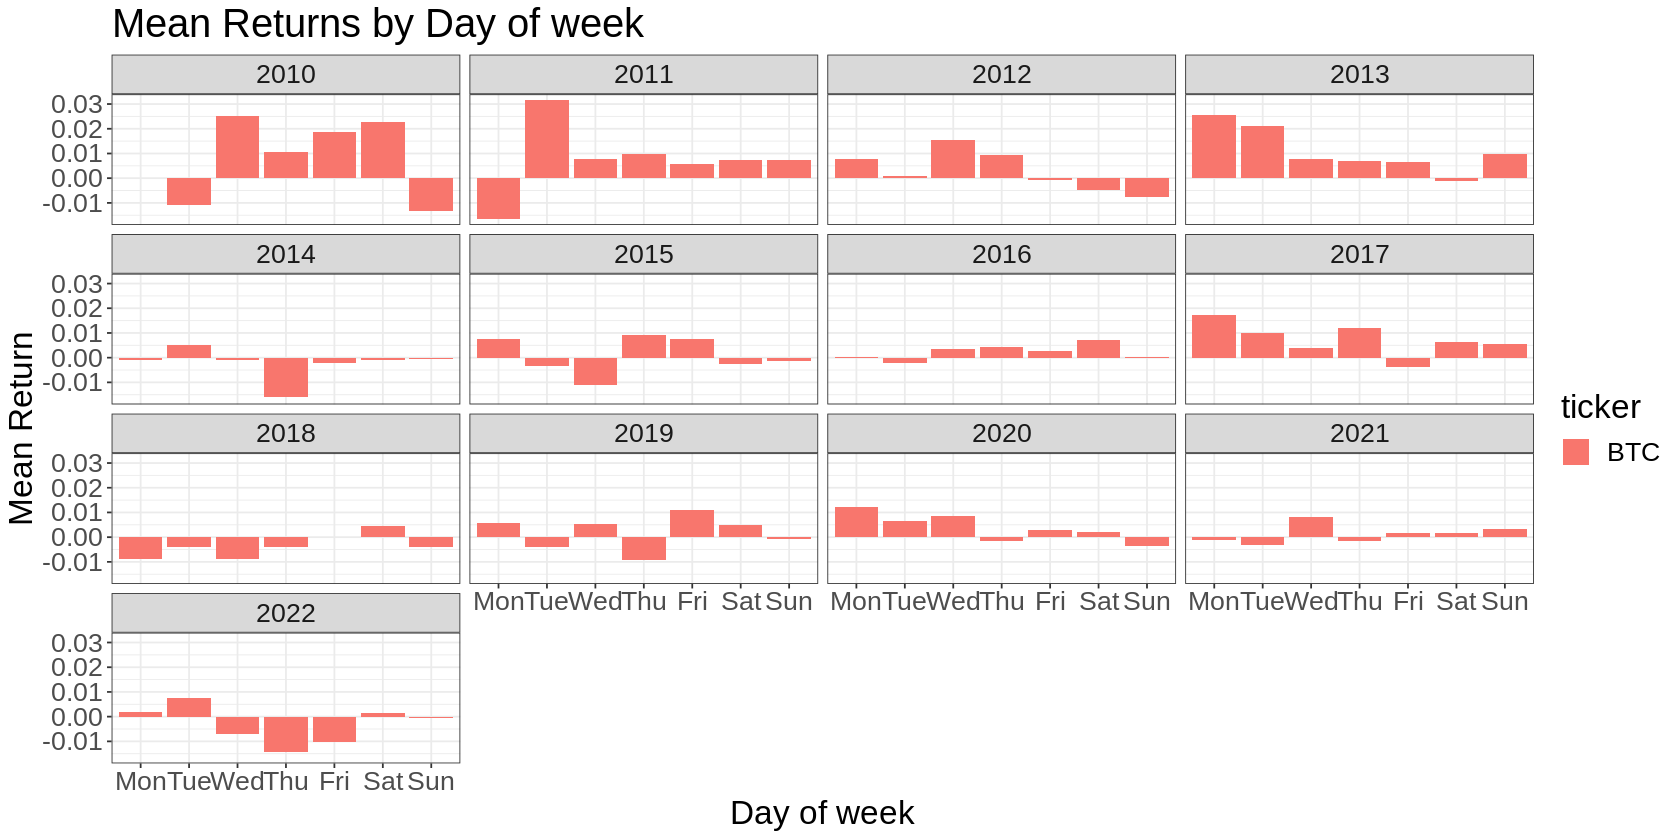

In [34]:
returns %>%
  mutate(day = factor(weekdays(date, abbreviate = TRUE), ordered = TRUE, levels = c('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')),
         year = year(date)) %>% 
  group_by(ticker, year, day) %>%
  summarise(mean_return = mean(log_return, na.rm = TRUE)) %>%
  ggplot(aes(x = day, y = mean_return, fill = ticker)) +
    geom_bar(stat = 'identity', position = position_dodge()) +
    labs(
      title = 'Mean Returns by Day of week', 
      x = 'Day of week', 
      y = 'Mean Return') +
    facet_wrap(~year) 

Finally let's look at day of the week seasonality of volatility.

`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


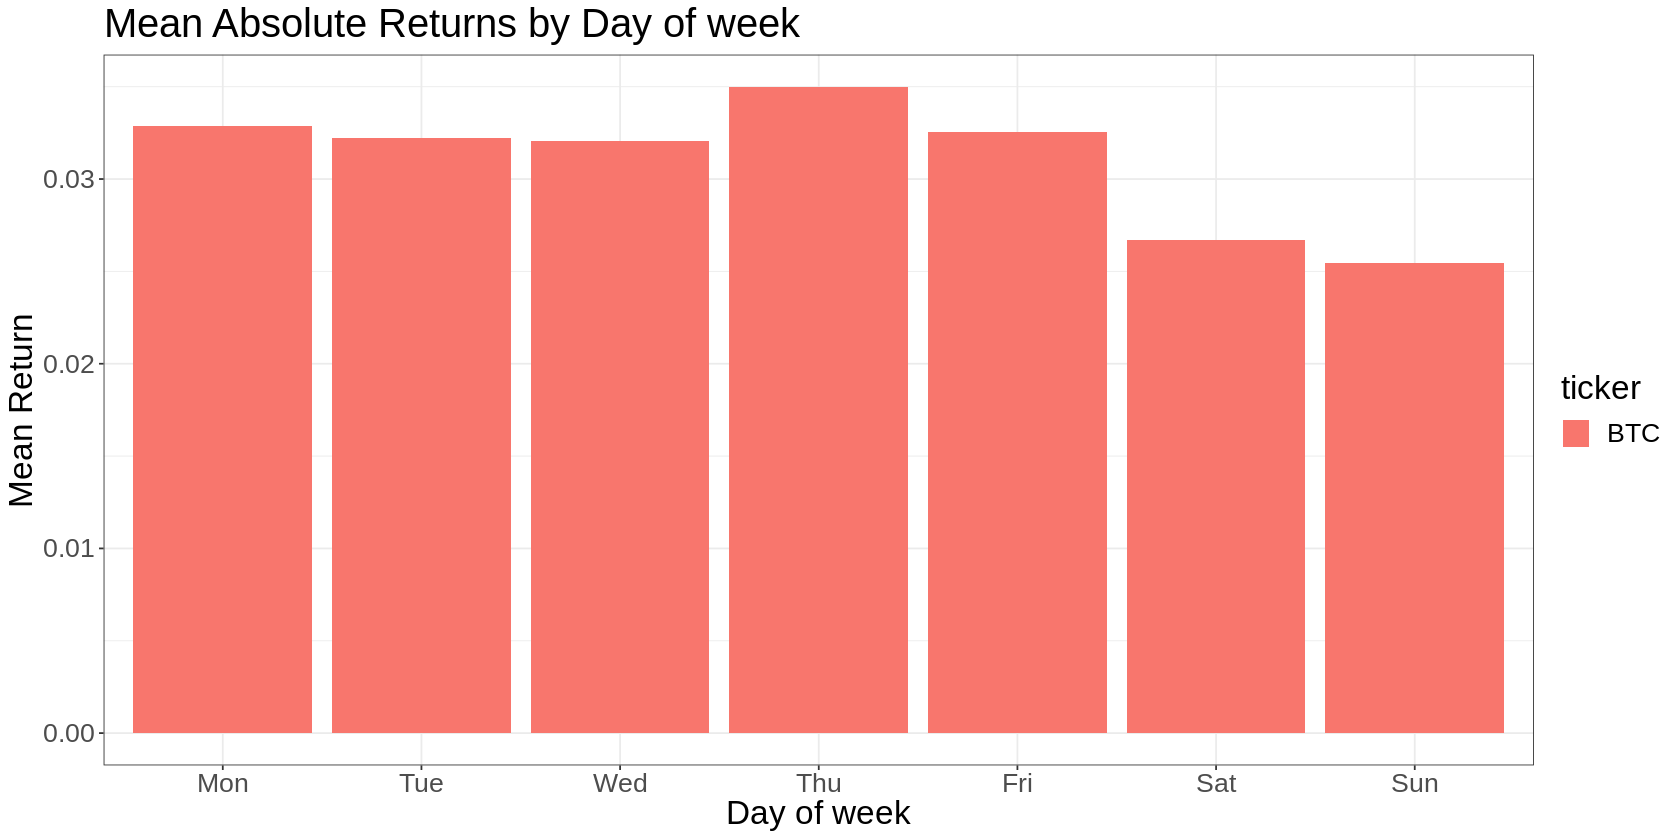

In [35]:
returns %>%
  mutate(day = factor(weekdays(date, abbreviate = TRUE), ordered = TRUE, levels = c('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')),
         year = year(date)) %>% 
  group_by(ticker, day) %>%
  summarise(mean_abs_return = mean(abs(simple_return), na.rm = TRUE)) %>%
  ggplot(aes(x = day, y = mean_abs_return, fill = ticker)) +
    geom_bar(stat = 'identity', position = position_dodge()) +
    labs(
      title = 'Mean Absolute Returns by Day of week', 
      x = 'Day of week', 
      y = 'Mean Return')

`summarise()` has grouped output by 'ticker', 'year'. You can override using
the `.groups` argument.


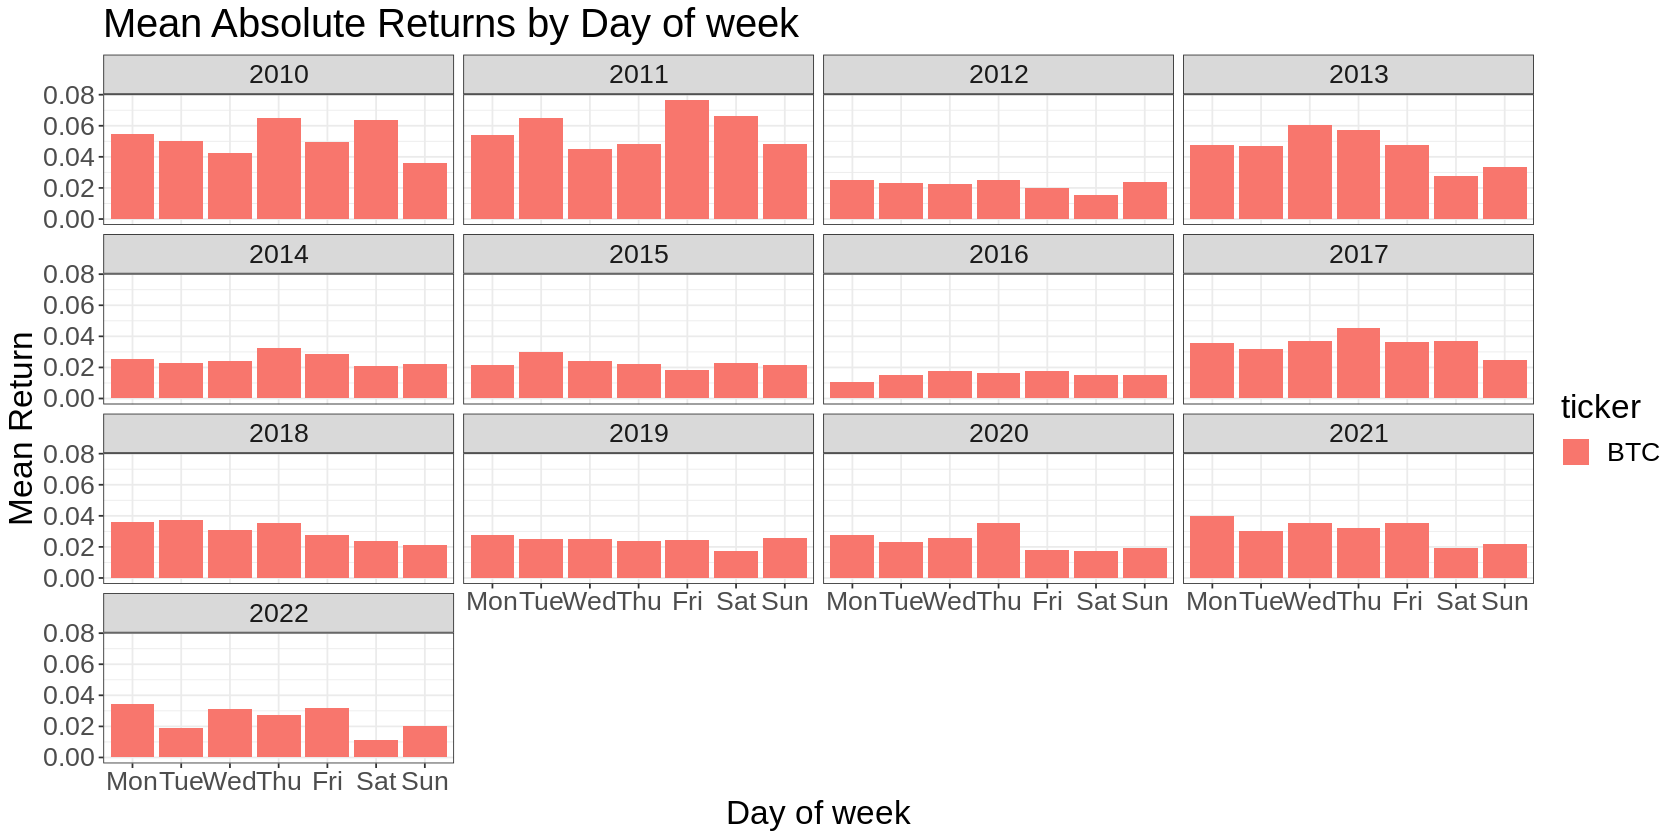

In [36]:
returns %>%
  mutate(day = factor(weekdays(date, abbreviate = TRUE), ordered = TRUE, levels = c('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')),
         year = year(date)) %>% 
  group_by(ticker, year, day) %>%
  summarise(mean_abs_return = mean(abs(simple_return), na.rm = TRUE)) %>%
  ggplot(aes(x = day, y = mean_abs_return, fill = ticker)) +
    geom_bar(stat = 'identity', position = position_dodge()) +
    labs(
      title = 'Mean Absolute Returns by Day of week', 
      x = 'Day of week', 
      y = 'Mean Return') +
      facet_wrap(~year)

# Summary

We find that:



*  Bitcoin returns are similar in nature to most other financial asset returns processes
*  They are more volatile and fat tailed
*  They are generally efficient in the time series
*  There are hints on short-term reversal and momentum effects
*  There are hints of seasonal regularities.

There is enough here to motivate further research.
